In [15]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# from sksurv.datasets import load_flchain
import torch.multiprocessing as mp

from pycox.evaluation import EvalSurv


# random_seed = 1991

# torch.manual_seed(random_seed)
# np.random.seed(random_seed)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# torch.backends.cudnn.benchmark = True
# device = 'cpu'

print(device)

cuda:0


In [16]:

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
from SurvNODE.EarlyStopping import EarlyStopping
from SurvNODE.SurvNODE import *
# from ODEsurv_autoregressive import *

In [18]:
def measures(odesurv,initial,x,Tstart,Tstop,From,To,trans,status, multiplier=1.,points=500):
    with torch.no_grad():
        time_grid = np.linspace(0, multiplier, points)
        pvec = torch.zeros((points,x.shape[0]))
        surv_ode = odesurv.predict(x,torch.from_numpy(np.linspace(0,multiplier,points)).float().to(x.device))
        pvec = torch.einsum("ilkj,k->ilj",(surv_ode[:,:,:,:],initial))[:,:,0].cpu()
        pvec = np.array(pvec.cpu().detach())
        surv_ode_df = pd.DataFrame(pvec)
        surv_ode_df.loc[:,"time"] = np.linspace(0,multiplier,points)
        surv_ode_df = surv_ode_df.set_index(["time"])
        ev_ode = EvalSurv(surv_ode_df, np.array(Tstop.cpu()), np.array(status.cpu()), censor_surv='km')
        conc = ev_ode.concordance_td('antolini')
        ibs = ev_ode.integrated_brier_score(time_grid)
        inbll = ev_ode.integrated_nbll(time_grid)
    return conc,ibs,inbll

# Multistate model

For the multistate model I need to solve the Kolmogorov Forward Equation

$$ \frac{d{\bf P(t_0,t)}}{dt} = {\bf P(t_0,t) Q(t)} $$

where $P_{ij} = p(s_j|s_i)$ are the transition probabilities and $Q_{ij} = \lim_{\Delta t\to 0} \frac{P(s_j,t+\Delta t|s_i,t)}{\Delta t}$ the transition rates. Furthermore the initial state should be $P_{ij}(t_0,t_0) = \delta_{ij}$.

The likelihood is given by the survival likelihood for each transition separately.

For every transition I can use a new NN or include the transition as a one-hot encoding.

In [22]:
num_in = 1
num_latent = 100
layers_encoder = [30]*1
dropout_encoder = [0.1]*1
layers_odefunc = [500]*1
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1.,1],[np.nan,np.nan,1],[np.nan,np.nan,np.nan]]).to(device)
print(trans_matrix)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(),weight_decay=1e-5)
# optimizer = torch.optim.RMSprop(odesurv.parameters(), weight_decay=0.01)
# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 2e-7)
# optimizer = torch.optim.Adagrad(odesurv.parameters(), weight_decay=0, lr=1e-2)
# optimizer = torch.optim.Adadelta(odesurv.parameters(), weight_decay=0)
# optimizer = torch.optim.AdamW(odesurv.parameters())
# optimizer = torch.optim.SGD(odesurv.parameters(), weight_decay=1e-5, lr=1e-4, momentum=0.1)
torch.cuda.empty_cache()

tensor([[nan, 1., 1.],
        [nan, nan, 1.],
        [nan, nan, nan]], device='cuda:0')


In [23]:
device

device(type='cuda', index=0)

In [24]:
%%time
_,ds = next(enumerate(val_loader))
myloss,_,_ = loss(odesurv,*ds)
print(myloss)
myloss.backward()

NameError: name 'val_loader' is not defined

In [25]:
odesurv.train()
for mini,ds in enumerate(train_loader):
    myloss,_,_ = loss(odesurv,*ds)
    optimizer.zero_grad()
    myloss.backward()    
    optimizer.step()

NameError: name 'train_loader' is not defined

## Dataset

In [26]:
# %%R -o ebmt3 -o ebmt3_train -o ebmt3_test -o prob_hr_train -o prob_lr_train -o prob_hr_test -o prob_lr_test -o Haz_lr -o Haz_hr
# library(mstate)
# library(dplyr)
# data(ebmt3)

# tmat <- transMat(list(c(2,3), c(3), c()))
# tmat <- trans.comprisk(2)
# tmat <- trans.illdeath()
# print(tmat)

# # ind <- sample(seq_len(nrow(ebmt3)), size = 1000)
# # ebmt3 <- ebmt3[ind, ]

# covs <- c("dissub", "age", "drmatch", "tcd")
# ebmt3 <- msprep(time = c(NA, "prtime", "rfstime"), status = c(NA,"prstat", "rfsstat"), data = ebmt3, trans = tmat, keep = covs)

# # ebmt3 <- ebmt3 %>% mutate(Tstart = runif(length(Tstart), 0, Tstop))

# test_ind <- sample((ebmt3 %>% distinct(id))$id, size = 128)
# test_id <- (ebmt3 %>% distinct(id))$id[test_ind]

# ebmt3_test <- ebmt3 %>% filter(id %in% test_id)
# ebmt3_train <- ebmt3 %>% filter(!id %in% test_id)

# long <- ebmt3_train %>% filter(dissub=="AML")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# Haz_hr <- msf0$Haz
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_hr_train <- pt0[[1]]

# long <- ebmt3_train %>% filter(dissub!="AML")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# Haz_lr <- msf0$Haz
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_lr_train <- pt0[[1]]

# long <- ebmt3_test %>% filter(dissub=="AML")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_hr_test <- pt0[[1]]

# long <- ebmt3_test %>% filter(dissub!="AML")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_lr_test <- pt0[[1]]


# ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = length(trans)==3 & trans==2) %>% filter(!delete)
# ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = !all(status==0) & !any(trans==3) & status!=1) %>% filter(!delete)
# ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = length(trans)==2 & all(status==0) & trans==1) %>% filter(!delete)

# ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = length(trans)==3 & trans==2) %>% filter(!delete)
# ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = !all(status==0) & !any(trans==3) & status!=1) %>% filter(!delete)
# ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = length(trans)==2 & all(status==0) & trans==1) %>% filter(!delete)

In [27]:
# %%R -o ebmt3 -o ebmt3_train -o ebmt3_test -o prob_hr_train -o prob_lr_train -o prob_hr_test -o prob_lr_test -o Haz_lr -o Haz_hr
# library(mstate)
# library(dplyr)
# data(prothr)

# ebmt3 <- prothr

# tmat <- transMat(list(c(2,3), c(1,3), c()))
# # tmat <- trans.comprisk(2)
# # tmat <- trans.illdeath()
# print(tmat)

# test_ind <- sample((ebmt3 %>% distinct(id))$id, size = 128)
# test_id <- (ebmt3 %>% distinct(id))$id[test_ind]

# ebmt3_test <- ebmt3 %>% filter(id %in% test_id)
# ebmt3_train <- ebmt3 %>% filter(!id %in% test_id)

# long <- ebmt3_train %>% filter(treat=="Placebo")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# Haz_hr <- msf0$Haz
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_hr_train <- pt0[[1]]

# long <- ebmt3_train %>% filter(treat!="Placebo")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# Haz_lr <- msf0$Haz
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_lr_train <- pt0[[1]]

# long <- ebmt3_test %>% filter(treat=="Placebo")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_hr_test <- pt0[[1]]

# long <- ebmt3_test %>% filter(treat!="Placebo")
# c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
# msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
# pt0 <- probtrans(msf0, predt = 0, method = "aalen")
# prob_lr_test <- pt0[[1]]

In [28]:
%%R -o prob_cox_lr -o prob_cox_hr -o ebmt3 -o ebmt3_train -o ebmt3_test -o prob_hr_train -o prob_lr_train -o prob_hr_test -o prob_lr_test -o Haz_lr -o Haz_hr

library(mstate)
library(genSurv)
library(dplyr)

cmmdata <- genCMM( n=2000, model.cens="uniform", cens.par=2.5, beta=c(2,1,-1),covar=3, rate=c(1,4,2,3,1,5) )
cmmdata <- cmmdata %>% mutate(from=ifelse(trans==1,1,ifelse(trans==2,1,2)),to=ifelse(trans==1,3,ifelse(trans==2,2,3)))
cmmdata <- cmmdata %>% rename(Tstart=start,Tstop=stop,status=event)

cmmdata <- cmmdata %>% mutate(covariate = covariate < 2)
cmmdata <- cmmdata %>% mutate(trans = ifelse(from==1 & to==3,2,ifelse(from==1 & to==2,1,3)))


ebmt3 <- cmmdata

# tmat <- transMat(list(c(2), c(), c(4), c()))
tmat <- trans.illdeath()
print(tmat)

cox <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans) + covariate, data = ebmt3, method = "breslow")

# predict cov=0
newd <- data.frame(covariate = rep(0, 3), trans = 1:3)
newd$strata = 1:3   
attr(newd, "trans") <- tmat
class(newd) <- c("msdata", "data.frame")
cox_cumhaz <- msfit(object = cox, newdata = newd, trans = tmat)
prob_cox <- probtrans(cox_cumhaz, predt = 0)
prob_cox_lr <- prob_cox[[1]]

# predict cov=1
newd <- data.frame(covariate = rep(1, 3), trans = 1:3)
newd$strata = 1:3   
attr(newd, "trans") <- tmat
class(newd) <- c("msdata", "data.frame")
cox_cumhaz <- msfit(object = cox, newdata = newd, trans = tmat)
prob_cox <- probtrans(cox_cumhaz, predt = 0)
prob_cox_hr <- prob_cox[[1]]

test_ind <- sample((ebmt3 %>% distinct(id))$id, size = 512)
test_id <- (ebmt3 %>% distinct(id))$id[test_ind]

ebmt3_test <- ebmt3 %>% filter(id %in% test_id)
ebmt3_train <- ebmt3 %>% filter(!id %in% test_id)

long <- ebmt3_train %>% filter(covariate==1)
c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
Haz_hr <- msf0$Haz
pt0 <- probtrans(msf0, predt = 0, method = "aalen")
prob_hr_train <- pt0[[1]]

long <- ebmt3_train %>% filter(covariate==0)
c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
Haz_lr <- msf0$Haz
pt0 <- probtrans(msf0, predt = 0, method = "aalen")
prob_lr_train <- pt0[[1]]

long <- ebmt3_test %>% filter(covariate==1)
c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
pt0 <- probtrans(msf0, predt = 0, method = "aalen")
prob_hr_test <- pt0[[1]]

long <- ebmt3_test %>% filter(covariate==0)
c0 <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = long, method = "breslow")
msf0 <- msfit(object = c0, vartype = "aalen", trans = tmat)
pt0 <- probtrans(msf0, predt = 0, method = "aalen")
prob_lr_test <- pt0[[1]]

ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = length(trans)==3 & trans==2) %>% filter(!delete)
ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = !all(status==0) & !any(trans==3) & status!=1) %>% filter(!delete)
ebmt3_train <- ebmt3_train %>% group_by(id) %>% mutate(delete = length(trans)==2 & all(status==0) & trans==1) %>% filter(!delete)

ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = length(trans)==3 & trans==2) %>% filter(!delete)
ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = !all(status==0) & !any(trans==3) & status!=1) %>% filter(!delete)
ebmt3_test <- ebmt3_test %>% group_by(id) %>% mutate(delete = length(trans)==2 & all(status==0) & trans==1) %>% filter(!delete)

R[write to console]: Error in library(mstate) : there is no package called 'mstate'


Error in library(mstate) : there is no package called 'mstate'


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\SEBAST~1\\AppData\\Local\\Temp\\tmpvj4etdx7\\Rplots001.png'

In [105]:
import pandas as pd
import numpy as np

def get_dataset(df):
    x = torch.from_numpy(np.array(df[["cov"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tmax = max(Tstop)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

ebmt3_train = pd.get_dummies(ebmt3_train)
ebmt3_train = ebmt3_train.rename(columns={'covariate': 'cov'})
ebmt3_test = pd.get_dummies(ebmt3_test)
ebmt3_test = ebmt3_test.rename(columns={'covariate': 'cov'})

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(ebmt3_train[["Tstop"]])).flatten().float().to(device))

df_train = ebmt3_train
df_test = ebmt3_test

train_loader = DataLoader(get_dataset(df_train), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_test), batch_size=128, shuffle=True)

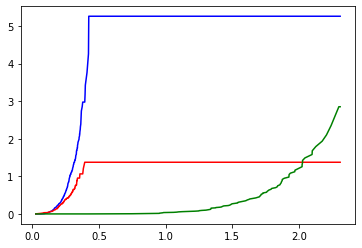

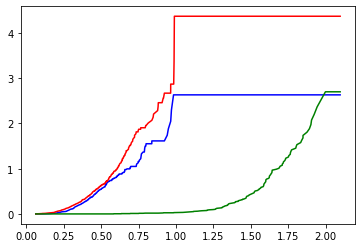

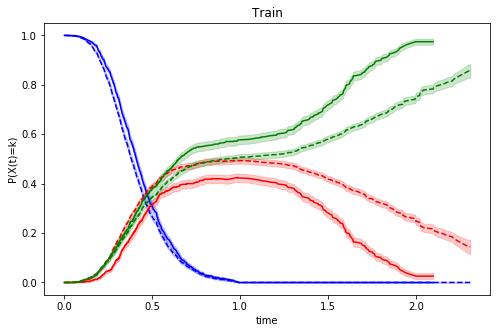

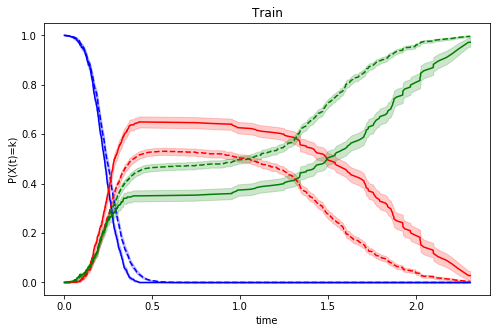

In [106]:
plt.figure()
col_vec = ["blue","red","green","orange"]
for trans in np.unique(Haz_lr["trans"]):
    temp = Haz_lr[Haz_lr.trans==trans]
    plt.plot(temp["time"],temp["Haz"],label=trans,color=col_vec[trans-1])
plt.show()
plt.figure()
for trans in np.unique(Haz_hr["trans"]):
    temp = Haz_hr[Haz_hr.trans==trans]
    plt.plot(temp["time"],temp["Haz"],label=trans,color=col_vec[trans-1])
plt.show()

plt.figure(figsize=(8,5))
col = ["blue","red","green","orange"]
for j in range(int((prob_hr_train.shape[1]-1)/2)):
    plt.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    plt.plot(prob_hr_train[["time"]],prob_hr_train[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_hr_train[["time"]]).flatten(),np.array(prob_hr_train[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_train[["se"+str(j+1)]]).flatten(),np.array(prob_hr_train[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_train[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
#         plt.xscale("log")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("Train")
plt.show()

plt.figure(figsize=(8,5))
col = ["blue","red","green","orange"]
for j in range(int((prob_hr_train.shape[1]-1)/2)):
    plt.plot(prob_lr_train[["time"]],prob_lr_train[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_lr_train[["time"]]).flatten(),np.array(prob_lr_train[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_train[["se"+str(j+1)]]).flatten(),np.array(prob_lr_train[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_train[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    plt.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("Train")
plt.show()

## Training

Validation loss decreased (inf --> 0.275807).  Saving model ...


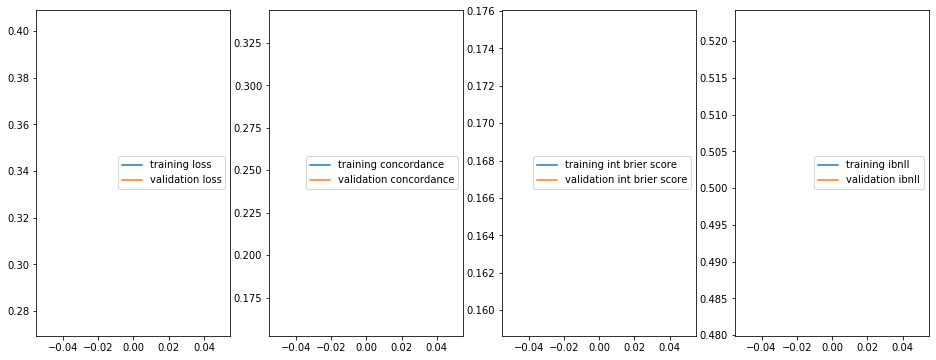

Validation loss decreased (0.275807 --> 0.052570).  Saving model ...
Validation loss decreased (0.052570 --> -0.048768).  Saving model ...
Validation loss decreased (-0.048768 --> -0.058342).  Saving model ...
Validation loss decreased (-0.058342 --> -0.106564).  Saving model ...
Validation loss decreased (-0.106564 --> -0.159032).  Saving model ...
Validation loss decreased (-0.159032 --> -0.191214).  Saving model ...
Validation loss decreased (-0.191214 --> -0.220278).  Saving model ...
Validation loss decreased (-0.220278 --> -0.247646).  Saving model ...
Validation loss decreased (-0.247646 --> -0.283994).  Saving model ...
Validation loss decreased (-0.283994 --> -0.309437).  Saving model ...


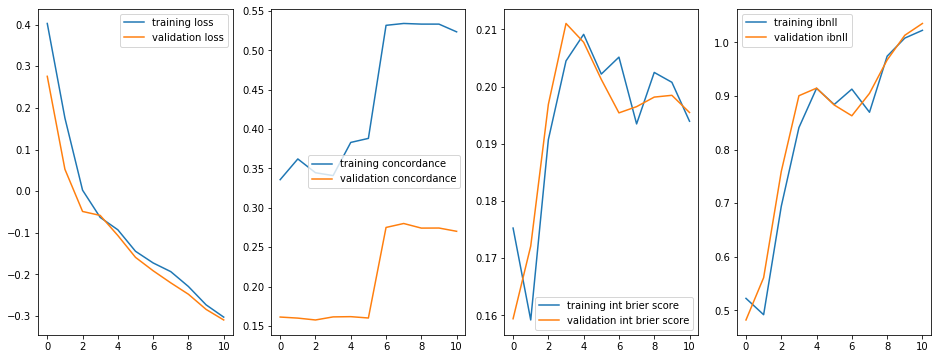

Validation loss decreased (-0.309437 --> -0.331751).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.331751 --> -0.336925).  Saving model ...
Validation loss decreased (-0.336925 --> -0.345313).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.345313 --> -0.347942).  Saving model ...
Validation loss decreased (-0.347942 --> -0.352820).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.352820 --> -0.360048).  Saving model ...


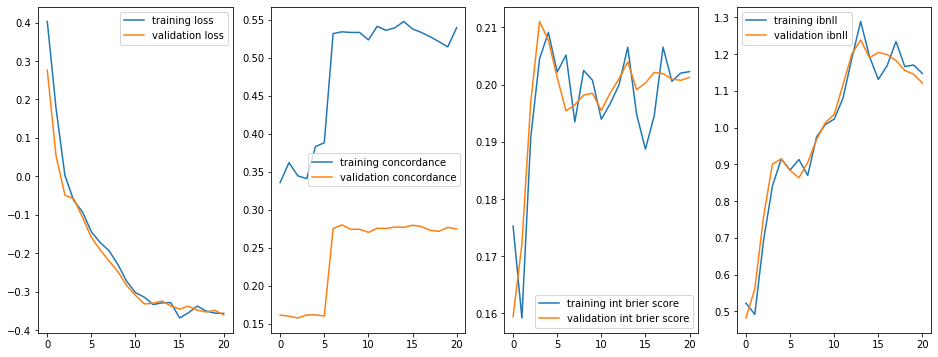

Validation loss decreased (-0.360048 --> -0.374115).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


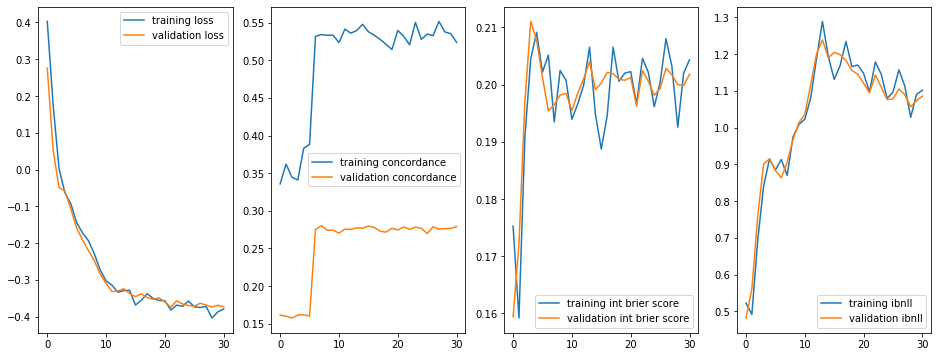

Validation loss decreased (-0.374115 --> -0.375162).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (-0.375162 --> -0.380607).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


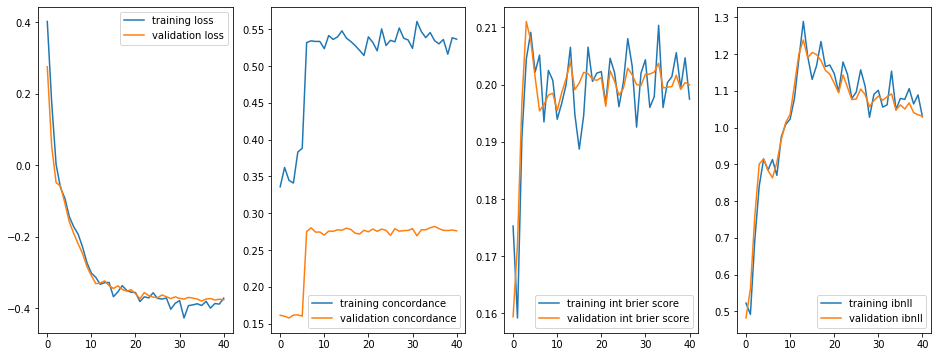

EarlyStopping counter: 6 out of 20
Validation loss decreased (-0.380607 --> -0.385840).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
Validation loss decreased (-0.385840 --> -0.390169).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.390169 --> -0.391380).  Saving model ...


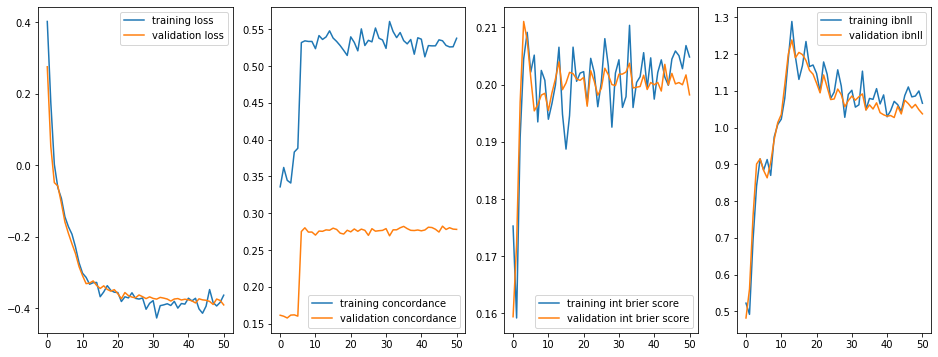

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (-0.391380 --> -0.395919).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.395919 --> -0.398174).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


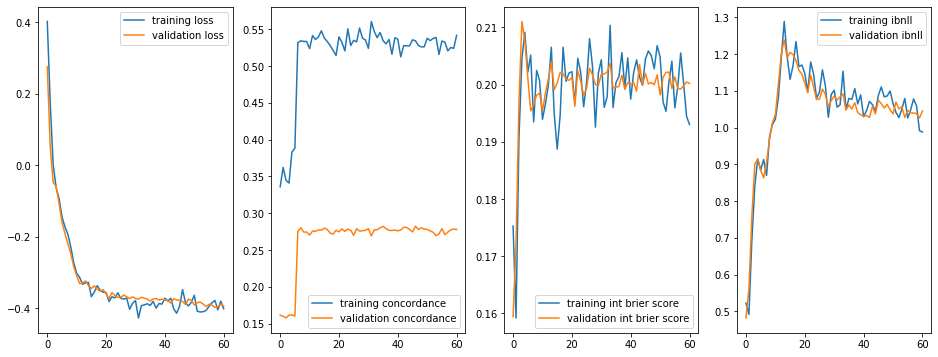

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (-0.398174 --> -0.399509).  Saving model ...
Validation loss decreased (-0.399509 --> -0.405219).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.405219 --> -0.405434).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.405434 --> -0.408740).  Saving model ...
Validation loss decreased (-0.408740 --> -0.416415).  Saving model ...


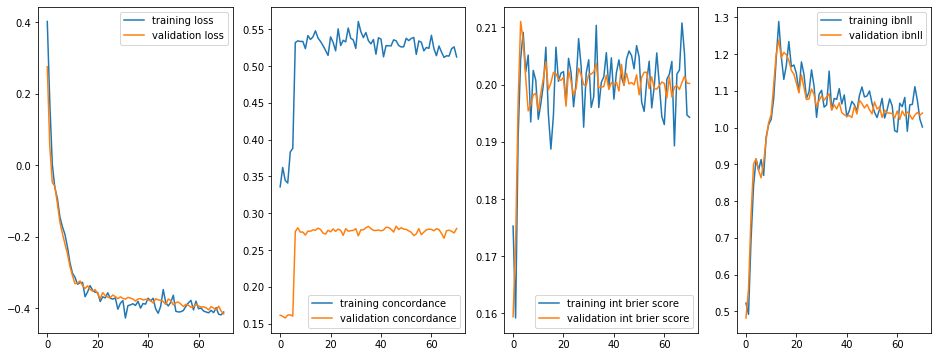

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (-0.416415 --> -0.416787).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (-0.416787 --> -0.417834).  Saving model ...


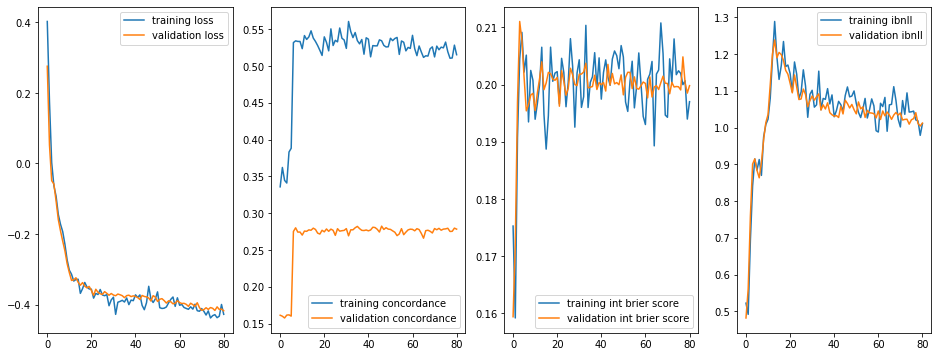

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (-0.417834 --> -0.423139).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


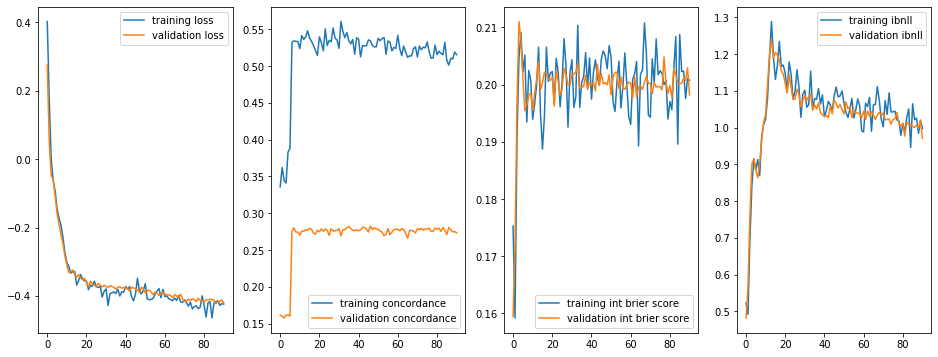

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
Validation loss decreased (-0.423139 --> -0.425005).  Saving model ...
Validation loss decreased (-0.425005 --> -0.426240).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


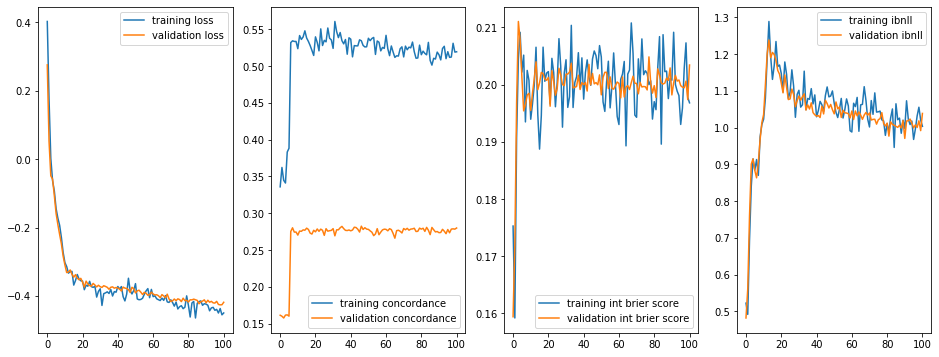

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (-0.426240 --> -0.427595).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (-0.427595 --> -0.429942).  Saving model ...


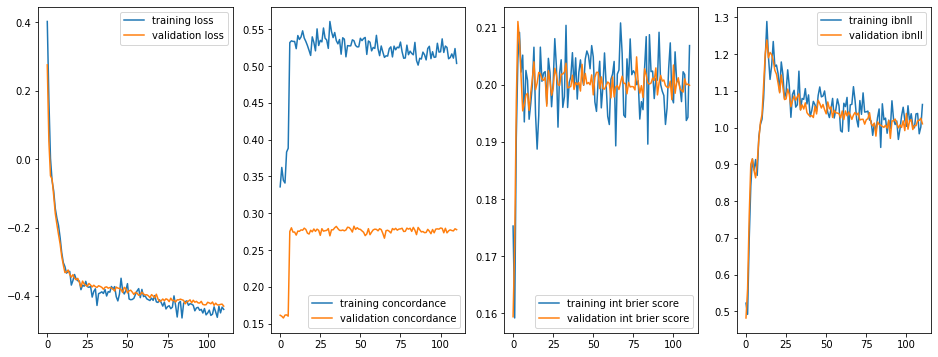

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20


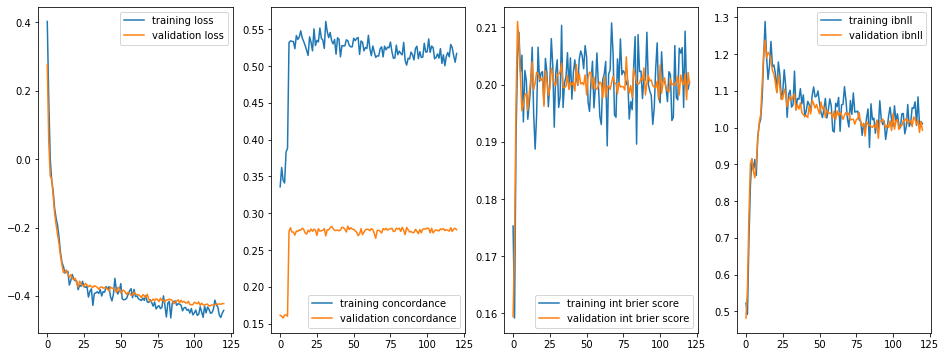

Validation loss decreased (-0.429942 --> -0.432370).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


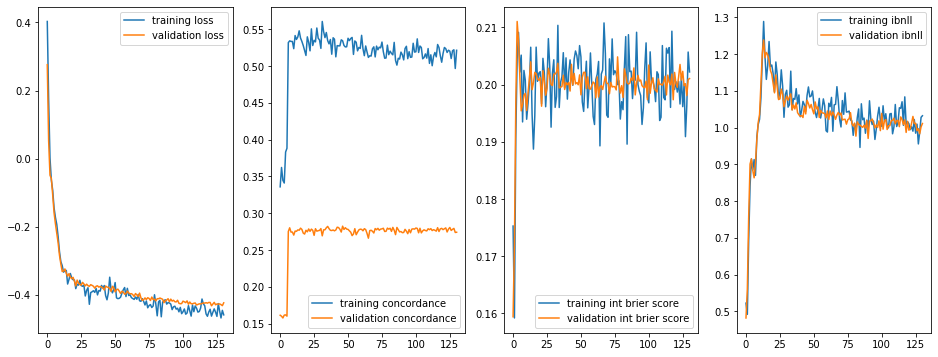

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20


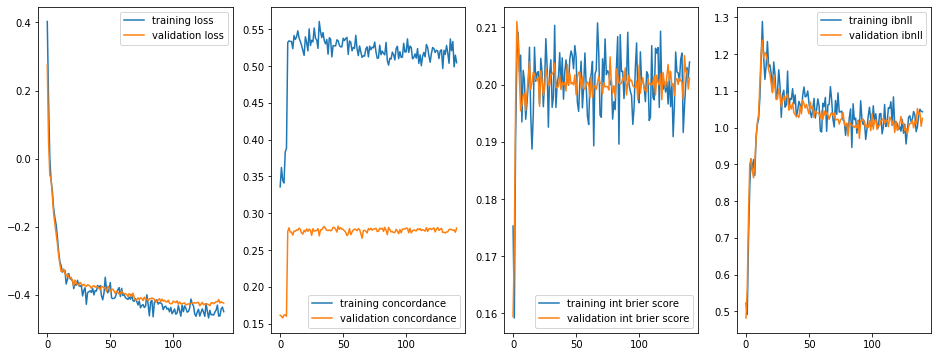

EarlyStopping counter: 20 out of 20
Early stopping


In [107]:
lossvals_train = []
lossvals_val = []
loglikes_train = []
loglikes_val = []
conc_val = []
conc_train = []
ibs_val = []
ibs_train = []
ibnll_val = []
ibnll_train = []
    
early_stopping = EarlyStopping("multistate_test",patience=20, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
    for mini,ds in enumerate(train_loader):
        myloss,t2,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()

        lossval += myloss.item()
        loglike += t2.item()
        t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.,0.],device=device),*ds)
        conc += t1
        ibs += t2
        ibnll += t3

    lossvals_train.append(lossval/len(train_loader))
    loglikes_train.append(loglike/len(train_loader))
    conc_train.append(conc/len(train_loader))
    ibs_train.append(ibs/len(train_loader))
    ibnll_train.append(ibnll/len(train_loader))
        
    odesurv.eval()
    with torch.no_grad():
        lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
        for _,ds in enumerate(val_loader):
            t1,t2,_ = loss(odesurv,*ds)
            lossval += t1.item()
            loglike += t2.item()
            t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.,0.],device=device),*ds)
            conc += t1
            ibs += t2
            ibnll += t3
        lossvals_val.append(lossval/len(val_loader))
        loglikes_val.append(loglike/len(val_loader))
        conc_val.append(conc/len(val_loader))
        ibs_val.append(ibs/len(val_loader))
        ibnll_val.append(ibnll/len(val_loader))
        early_stopping(lossval/len(val_loader), odesurv)

    if early_stopping.early_stop:
        print("Early stopping")
        break
            
    if i%10==0:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,6))
        ax2.plot(conc_train, label="training concordance")
        ax2.plot(conc_val, label="validation concordance")
        ax2.legend()
        ax3.plot(ibs_train, label="training int brier score")
        ax3.plot(ibs_val, label="validation int brier score")
        ax3.legend()
        ax1.plot(lossvals_train,label="training loss")
        ax1.plot(lossvals_val, label="validation loss")
        ax1.legend()
        ax4.plot(ibnll_train,label="training ibnll")
        ax4.plot(ibnll_val, label="validation ibnll")
        ax4.legend()
        plt.show()



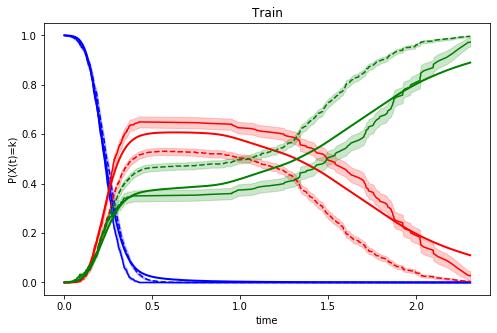

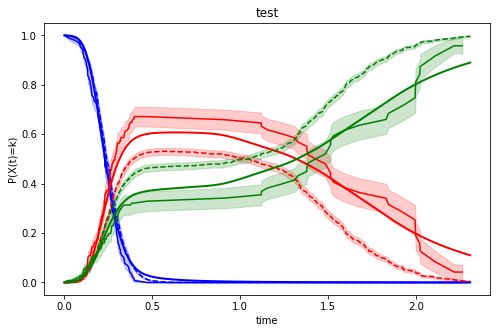

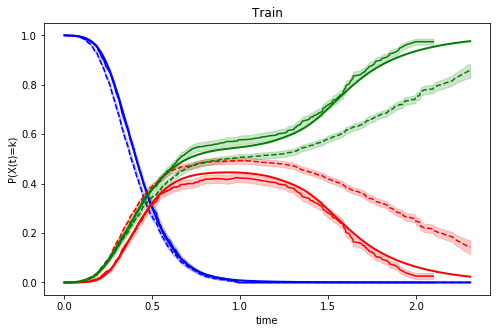

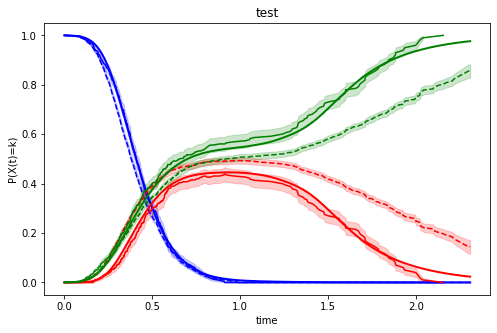

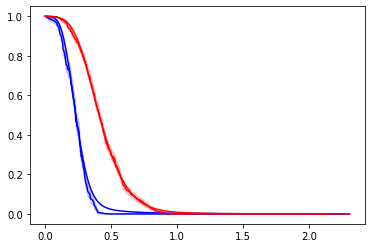

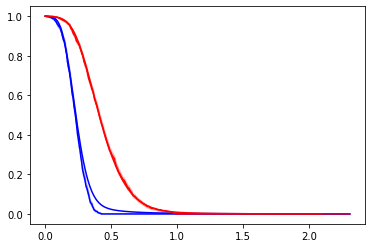

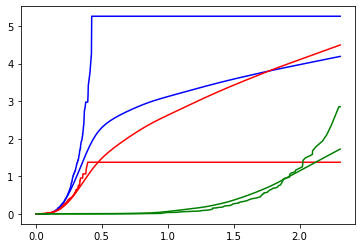

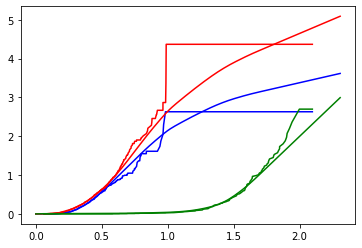

In [108]:
temp_t = torch.from_numpy(np.linspace(0.,1.0,200))
with torch.no_grad():
    out = odesurv.predict(torch.tensor([[0.],[1.]],device=device),temp_t).cpu()

# covariate = 0
pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.,0.])))

## train set
plt.figure(figsize=(8,5))
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    plt.plot(np.array(temp_t)*np.array(Tmax.cpu()),pvec[:,j],color=col[j],lw=2)
    
    plt.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)

    plt.plot(prob_lr_train[["time"]],prob_lr_train[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_lr_train[["time"]]).flatten(),np.array(prob_lr_train[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_train[["se"+str(j+1)]]).flatten(),np.array(prob_lr_train[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_train[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
#         plt.xscale("log")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("Train")
plt.show()
## test set
plt.figure(figsize=(8,5))
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    plt.plot(np.array(temp_t)*np.array(Tmax.cpu()),pvec[:,j],color=col[j],lw=2)
    
    plt.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)

    plt.plot(prob_lr_test[["time"]],prob_lr_test[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_lr_test[["time"]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
#         plt.xscale("log")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("test")
plt.show()


# covariate = 1
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.,0.])))

## train set
plt.figure(figsize=(8,5))
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    plt.plot(np.array(temp_t)*np.array(Tmax.cpu()),pvec[:,j],color=col[j],lw=2)
    
    plt.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)

    plt.plot(prob_hr_train[["time"]],prob_hr_train[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_hr_train[["time"]]).flatten(),np.array(prob_hr_train[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_train[["se"+str(j+1)]]).flatten(),np.array(prob_hr_train[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_train[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
#         plt.xscale("log")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("Train")
plt.show()
## test set
plt.figure(figsize=(8,5))
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    plt.plot(np.array(temp_t)*np.array(Tmax.cpu()),pvec[:,j],color=col[j],lw=2)
    
    plt.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col[j], ls="--")
    plt.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    
    plt.plot(prob_hr_test[["time"]],prob_hr_test[["pstate"+str(j+1)]],color=col[j])
    plt.fill_between(np.array(prob_hr_test[["time"]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
#         plt.xscale("log")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
plt.title("test")
plt.show()

ax = plt.subplot(111)
pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.,0.])))
ax.plot(np.array(temp_t)*np.array(Tmax.cpu()),np.array(pvec[:,0]),color='blue')
ax.plot(prob_lr_test[["time"]],prob_lr_test[["pstate1"]],color="blue")
ax.fill_between(np.array(prob_lr_test[["time"]]).flatten(),np.array(prob_lr_test[["pstate1"]]).flatten()-np.array(prob_lr_test[["se1"]]).flatten(),np.array(prob_lr_test[["pstate1"]]).flatten()+np.array(prob_lr_test[["se1"]]).flatten(),color="blue",alpha=0.2)
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.,0.])))
ax.plot(np.array(temp_t)*np.array(Tmax.cpu()),np.array(pvec[:,0]),color='red')
ax.plot(prob_hr_test[["time"]],prob_hr_test[["pstate1"]],color="red")
ax.fill_between(np.array(prob_hr_test[["time"]]).flatten(),np.array(prob_hr_test[["pstate1"]]).flatten()-np.array(prob_hr_test[["se1"]]).flatten(),np.array(prob_hr_test[["pstate1"]]).flatten()+np.array(prob_hr_test[["se1"]]).flatten(),color="red",alpha=0.2)
#         kmf_exp_test.plot(ax=ax,c="red")
#         kmf_con_test.plot(ax=ax,c="blue")
#         kmf_full.plot(ax=ax)
plt.show()
ax = plt.subplot(111)
pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.,0.])))
ax.plot(np.array(temp_t)*np.array(Tmax.cpu()),np.array(pvec[:,0]),color='blue')
ax.plot(prob_lr_train[["time"]],prob_lr_train[["pstate1"]],color="blue")
ax.fill_between(np.array(prob_lr_train[["time"]]).flatten(),np.array(prob_lr_train[["pstate1"]]).flatten()-np.array(prob_lr_train[["se1"]]).flatten(),np.array(prob_lr_train[["pstate1"]]).flatten()+np.array(prob_lr_train[["se1"]]).flatten(),color="blue",alpha=0.2)
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.,0.])))
ax.plot(np.array(temp_t)*np.array(Tmax.cpu()),np.array(pvec[:,0]),color='red')
ax.plot(prob_hr_train[["time"]],prob_hr_train[["pstate1"]],color="red")
ax.fill_between(np.array(prob_hr_train[["time"]]).flatten(),np.array(prob_hr_train[["pstate1"]]).flatten()-np.array(prob_hr_train[["se1"]]).flatten(),np.array(prob_hr_train[["pstate1"]]).flatten()+np.array(prob_hr_train[["se1"]]).flatten(),color="red",alpha=0.2)
#         kmf_exp_train.plot(ax=ax,c="red")
#         kmf_con_train.plot(ax=ax,c="blue")
#         kmf_full.plot(ax=ax)
plt.show()

Qvec = odesurv.predict_cumhazard(torch.tensor([[0.],[1.]],device="cuda:0"),torch.from_numpy(np.linspace(0,1,200)).float())
Qvec = Qvec[Qvec!=0].reshape((Qvec.shape[0]-1,Qvec.shape[1],odesurv.number_of_hazards))
Qvec = torch.cat((torch.zeros((1,Qvec.shape[1],Qvec.shape[2]),device=Qvec.device),Qvec),dim=0)
plt.figure()
col_vec = ["blue","red","green"]
for trans in np.unique(Haz_lr["trans"]):
    plt.plot(np.linspace(0,1,200)*np.array(Tmax.cpu()),np.array(Qvec[:,0,trans-1].cpu()),color=col_vec[trans-1])
    temp = Haz_lr[Haz_lr.trans==trans]
    plt.plot(temp["time"],temp["Haz"],label=trans,color=col_vec[trans-1])
plt.show()
plt.figure()
col_vec = ["blue","red","green"]
for trans in np.unique(Haz_hr["trans"]):
    plt.plot(np.linspace(0,1,200)*np.array(Tmax.cpu()),np.array(Qvec[:,1,trans-1].cpu()),color=col_vec[trans-1])
    temp = Haz_hr[Haz_hr.trans==trans]
    plt.plot(temp["time"],temp["Haz"],label=trans,color=col_vec[trans-1])
plt.show()

# Competing Hazards

In [15]:
url = 'https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/SYNTHETIC/synthetic_comprisk.csv'
df_train = pd.read_csv(url)

# df_train = df_train.loc[df_train.time!=0,:]
df_train.loc[df_train.time==0,"time"] = 0.5

df_train.loc[:,"Tstop"] = df_train.loc[:,"time"].astype("float32")
df_train.loc[:,"Tstart"] = 0.
df_train.loc[:,"status"] = df_train.loc[:,"label"]>0
df_train.loc[:,"from"] = 1
df_train.loc[:,"to"] = df_train.loc[:,"true_label"]+1
df_train.loc[:,"trans"] = df_train.loc[:,"true_label"]

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

In [16]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

get_x = lambda df: (df
                    .drop(columns=['time', 'label', 'true_time', 'true_label',"Tstart","Tstop","from","to","status","trans"])
                    .values.astype('float32'))

x_train = get_x(df_train)
x_val = get_x(df_val)
x_test = get_x(df_test)

multiplier = 2.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

In [17]:
import pandas as pd
import numpy as np

def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["feature"+str(i) for i in range(1,13)]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

train_loader = DataLoader(get_dataset(df_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(df_test,Tmax), batch_size=512, shuffle=True)

In [18]:
num_in = 12
num_latent = 30
layers_encoder = [400]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*2
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1.,1.],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]]).to(device)
print(trans_matrix)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(),weight_decay=1e-7, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

tensor([[nan, 1., 1.],
        [nan, nan, nan],
        [nan, nan, nan]], device='cuda:1')


Validation loss decreased (inf --> 0.309026).  Saving model ...


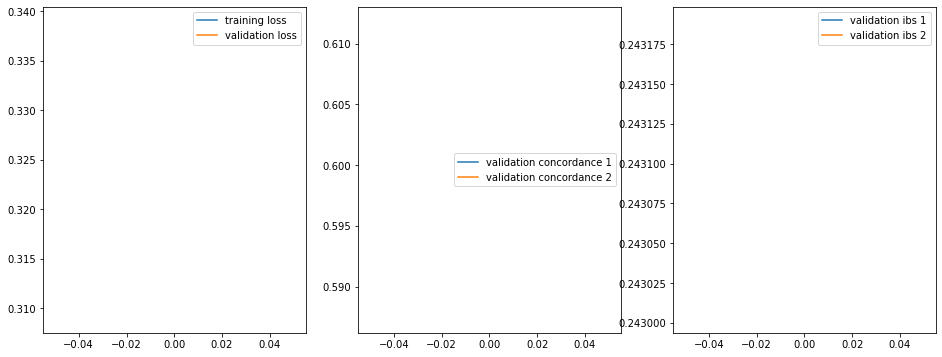

Validation loss decreased (0.309026 --> 0.283584).  Saving model ...
Validation loss decreased (0.283584 --> 0.237033).  Saving model ...
Validation loss decreased (0.237033 --> 0.208570).  Saving model ...
Validation loss decreased (0.208570 --> 0.182850).  Saving model ...
Validation loss decreased (0.182850 --> 0.173237).  Saving model ...
Validation loss decreased (0.173237 --> 0.163130).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.163130 --> 0.157546).  Saving model ...
Validation loss decreased (0.157546 --> 0.156196).  Saving model ...
EarlyStopping counter: 1 out of 10


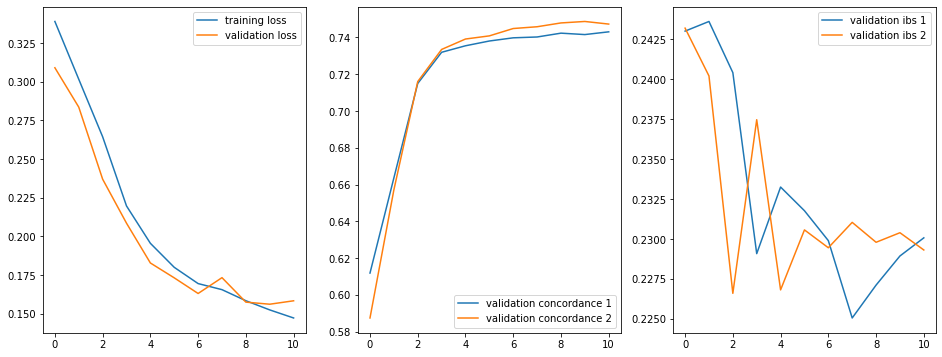

EarlyStopping counter: 2 out of 10
Validation loss decreased (0.156196 --> 0.149097).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss decreased (0.149097 --> 0.148834).  Saving model ...
Validation loss decreased (0.148834 --> 0.148815).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10


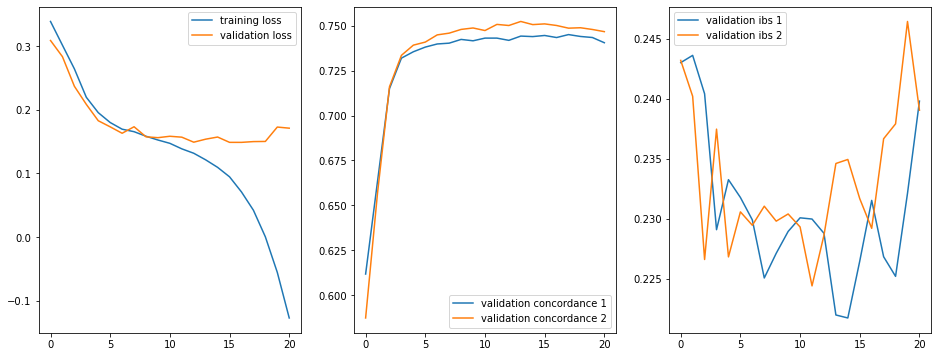

EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Early stopping



<All keys matched successfully>

In [19]:
# optimizer = torch.optim.Adam(odesurv.parameters(),weight_decay=1e-7, lr=1e-4)

lossvals_train = []
lossvals_val = []
loglikes_train = []
loglikes_val = []
conc_val1 = []
conc_val2 = []
conc_train = []
ibs_val1 = []
ibs_val2 = []
ibs_train = []
ibnll_val = []
ibnll_train = []
    
early_stopping = EarlyStopping("multistate_test",patience=10, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    lossval = 0.
    for _,ds in enumerate(train_loader):
        myloss,_,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()
        lossval += myloss.item()
    lossvals_train.append(lossval/len(train_loader))
        
    odesurv.eval()
    with torch.no_grad():
        lossval = 0.
        temp_t = torch.from_numpy(np.linspace(0.,multiplier*1.0,500))
        prediction = []
        durations_vec = []
        events_vec = []
        to_vec = []
        with torch.no_grad():
            for df in val_loader:
                myloss,_,_ = loss(odesurv,*df)
                lossval += myloss.item()
                out = odesurv.predict(df[0],temp_t).cpu()
                pvec = torch.einsum("ilkj,k->ilj",(out,torch.tensor([1.,0.,0.])))
                prediction.append(pvec)
                durations_vec.append(df[2])
                events_vec.append(df[6])
                to_vec.append(df[4])
        prediction = torch.cat(prediction,dim=1)
        durations_vec = torch.cat(durations_vec)
        events_vec = torch.cat(events_vec)
        to_vec = torch.cat(to_vec)

        cif1 = pd.DataFrame(1-prediction[:,:,1].numpy())
        cif1 = cif1.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())
        cif2 = pd.DataFrame(1-prediction[:,:,2].numpy())
        cif2 = cif2.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())

        ev1 = EvalSurv(cif1, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==2).cpu().numpy(), censor_surv='km')
        ev2 = EvalSurv(cif2, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==3).cpu().numpy(), censor_surv='km')
        conc1 = ev1.concordance_td("antolini")
        conc2 = ev2.concordance_td("antolini")
        time_grid = np.linspace(0, Tmax.item(), 200)
        ibs1 = ev1.integrated_brier_score(time_grid)
        ibs2 = ev2.integrated_brier_score(time_grid)
        
        lossvals_val.append(lossval/len(val_loader))
        conc_val1.append(conc1)
        conc_val2.append(conc2)
        ibs_val1.append(ibs1)
        ibs_val2.append(ibs2)
        early_stopping(lossval/len(val_loader), odesurv)
    
#     scheduler.step(lossval/len(val_loader))

    if early_stopping.early_stop:
        print("Early stopping")
        break
            
    if i%10==0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
        ax2.plot(conc_val1, label="validation concordance 1")
        ax2.plot(conc_val2, label="validation concordance 2")
        ax2.legend()
        ax3.plot(ibs_val1, label="validation ibs 1")
        ax3.plot(ibs_val2, label="validation ibs 2")
        ax3.legend()
        ax1.plot(lossvals_train,label="training loss")
        ax1.plot(lossvals_val, label="validation loss")
        ax1.legend()
        plt.show()
        
odesurv.load_state_dict(torch.load('multistate_test_checkpoint.pt'))

In [20]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier,500))
prediction = []
durations_vec = []
events_vec = []
to_vec = []
for df in test_loader:
    myloss,_,_ = loss(odesurv,*df)
    lossval += myloss.item()
    out = odesurv.predict(df[0],temp_t).cpu()
    pvec = torch.einsum("ilkj,k->ilj",(out,torch.tensor([1.,0.,0.])))
    prediction.append(pvec)
    durations_vec.append(df[2])
    events_vec.append(df[6])
    to_vec.append(df[4])
prediction = torch.cat(prediction,dim=1)
durations_vec = torch.cat(durations_vec)
events_vec = torch.cat(events_vec)
to_vec = torch.cat(to_vec)

cif1 = pd.DataFrame(1-prediction[:,:,1].numpy())
cif1 = cif1.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())
cif2 = pd.DataFrame(1-prediction[:,:,2].numpy())
cif2 = cif2.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())

ev1 = EvalSurv(cif1, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==2).cpu().numpy(), censor_surv='km')
ev2 = EvalSurv(cif2, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==3).cpu().numpy(), censor_surv='km')
conc1 = ev1.concordance_td("antolini")
conc2 = ev2.concordance_td("antolini")
time_grid = np.linspace(0, Tmax.item(), 500)
ibs1 = ev1.integrated_brier_score(time_grid)
ibs2 = ev2.integrated_brier_score(time_grid)
print(conc1,conc2)
print(ibs1,ibs2)

0.7373262200932004 0.7354096009664735
0.22898368053000015 0.2321363663374415


In [39]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier,500))
prediction = []
durations_vec = []
events_vec = []
to_vec = []
for df in test_loader:
    myloss,_,_ = loss(odesurv,*df)
    lossval += myloss.item()
    out = odesurv.predict(df[0],temp_t).cpu()
    pvec = torch.einsum("ilkj,k->ilj",(out,torch.tensor([1.,0.,0.])))
    prediction.append(pvec)
    durations_vec.append(df[2])
    events_vec.append(df[6])
    to_vec.append(df[4])
prediction = torch.cat(prediction,dim=1)
durations_vec = torch.cat(durations_vec)
events_vec = torch.cat(events_vec)
to_vec = torch.cat(to_vec)

cif1 = pd.DataFrame(1-prediction[:,:,1].numpy())
cif1 = cif1.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())
cif2 = pd.DataFrame(1-prediction[:,:,2].numpy())
cif2 = cif2.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())

ev1 = EvalSurv(cif1, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==2).cpu().numpy(), censor_surv='km')
ev2 = EvalSurv(cif2, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==3).cpu().numpy(), censor_surv='km')
conc1 = ev1.concordance_td("antolini")
conc2 = ev2.concordance_td("antolini")
time_grid = np.linspace(0, Tmax.item(), 500)
ibs1 = ev1.integrated_brier_score(time_grid)
ibs2 = ev2.integrated_brier_score(time_grid)
print(conc1,conc2)
print(ibs1,ibs2)

0.7431428473490852 0.737590234767951
0.2245630613002975 0.23552899659375273


In [40]:
print(np.mean([0.737,0.743,0.7276,0.7314,0.7431]))
print(np.std([0.737,0.743,0.7276,0.7314,0.7431]))
print(np.mean([0.747,0.737,0.7467,0.7288,0.73759]))
print(np.std([0.747,0.737,0.7467,0.7288,0.73759]))

0.7364200000000001
0.006184626100258588
0.739418
0.006818276615098576


In [11]:
df_trainval = pd.concat((df_train,df_val))

In [12]:
%%R -i df_trainval -i df_test -o prediction_df1
library(survival)
library(dplyr)

df_trainval <- df_trainval %>% filter(trans==1)
df_test <- df_test %>% filter(trans==1)

cox1 <- coxph(Surv(Tstop,status) ~ feature1 + feature2 + feature3 + feature4 + feature5 + feature6 + feature7 + feature8 + feature9 + feature10 + feature11 + feature12,df_trainval)

maxt <- max(df_test$Tstop)
prediction_df1 <- data.frame(time=eval(1:maxt))
for (i in 1:dim(df_test)[1]) {
    test_data <- data.frame(Tstop=eval(1:maxt))
    test_data$status <- 1
    test_data$feature1 <- df_test$feature1[i]
    test_data$feature2 <- df_test$feature2[i]
    test_data$feature3 <- df_test$feature3[i]
    test_data$feature4 <- df_test$feature4[i]
    test_data$feature5 <- df_test$feature5[i]
    test_data$feature6 <- df_test$feature6[i]
    test_data$feature7 <- df_test$feature7[i]
    test_data$feature8 <- df_test$feature8[i]
    test_data$feature9 <- df_test$feature9[i]
    test_data$feature10 <- df_test$feature10[i]
    test_data$feature11 <- df_test$feature11[i]
    test_data$feature12 <- df_test$feature12[i]
    prediction <- predict(cox1,test_data,type="expected",se.fit=T)
    temp <- data.frame(time=eval(1:maxt),prediction_mean=prediction$fit)
    names(temp) <- c("time",paste("mean_",rownames(df_test)[i],sep=""))
    prediction_df1 <- inner_join(prediction_df1,temp,by="time")
}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [13]:
%%R -i df_trainval -i df_test -o prediction_df2
library(survival)
library(dplyr)

df_trainval <- df_trainval %>% filter(trans==2)
df_test <- df_test %>% filter(trans==2)

cox2 <- coxph(Surv(Tstop,status) ~ feature1 + feature2 + feature3 + feature4 + feature5 + feature6 + feature7 + feature8 + feature9 + feature10 + feature11 + feature12,df_trainval)

maxt <- max(df_test$Tstop)
prediction_df2 <- data.frame(time=eval(1:maxt))
for (i in 1:dim(df_test)[1]) {
    test_data <- data.frame(Tstop=eval(1:maxt))
    test_data$status <- 1
    test_data$feature1 <- df_test$feature1[i]
    test_data$feature2 <- df_test$feature2[i]
    test_data$feature3 <- df_test$feature3[i]
    test_data$feature4 <- df_test$feature4[i]
    test_data$feature5 <- df_test$feature5[i]
    test_data$feature6 <- df_test$feature6[i]
    test_data$feature7 <- df_test$feature7[i]
    test_data$feature8 <- df_test$feature8[i]
    test_data$feature9 <- df_test$feature9[i]
    test_data$feature10 <- df_test$feature10[i]
    test_data$feature11 <- df_test$feature11[i]
    test_data$feature12 <- df_test$feature12[i]
    prediction <- predict(cox2,test_data,type="expected",se.fit=T)
    temp <- data.frame(time=eval(1:maxt),prediction_mean=prediction$fit)
    names(temp) <- c("time",paste("mean_",rownames(df_test)[i],sep=""))
    prediction_df2 <- inner_join(prediction_df2,temp,by="time")
}

In [14]:
prediction_df1 = prediction_df1.set_index(["time"])
prediction_df2 = prediction_df2.set_index(["time"])
df_pred1 = pd.DataFrame()
df_pred2 = pd.DataFrame()
for i in prediction_df1.columns:
    df_pred1.loc[:,i] = np.exp(-prediction_df1.loc[:,i])
for i in prediction_df2.columns:
    df_pred2.loc[:,i] = np.exp(-prediction_df2.loc[:,i])

In [15]:
time_grid = np.linspace(0, df_test[df_test.trans==1].Tstop.max(), 500)
ev_ode1 = EvalSurv(df_pred1, df_test[df_test.trans==1].loc[:,"Tstop"].values, df_test[df_test.trans==1].loc[:,"status"].values, censor_surv='km')
print(ev_ode1.concordance_td("antolini"))
print(ev_ode1.integrated_brier_score(time_grid))
print(ev_ode1.integrated_nbll(time_grid))

0.5442133319664779
0.10393454301215856
0.3290422008462672


In [16]:
time_grid = np.linspace(0, df_test[df_test.trans==2].Tstop.max(), 500)
ev_ode1 = EvalSurv(df_pred2, df_test[df_test.trans==2].loc[:,"Tstop"].values, df_test[df_test.trans==2].loc[:,"status"].values, censor_surv='km')
print(ev_ode1.concordance_td('antolini'))
print(ev_ode1.integrated_brier_score(time_grid))
print(ev_ode1.integrated_nbll(time_grid))

0.5565996586535709
0.11195019373344721
0.35732743955398233


## Simple survival

In [7]:
from lifelines.datasets import load_waltons


df = load_waltons()
multiplier = 1.

x = torch.from_numpy(np.array([[x] for x in df["group"].apply(lambda x: 1 if x=="miR-137" else 0)])).float().to(device)
# x = torch.from_numpy(np.array([[x] for x in df["group"].apply(lambda x: 0 if x=="miR-137" else 0)])).float()
T = torch.from_numpy(np.array(df["T"])).float().to(device)
T[T==0.]=1e-4
Tmax = max(T)
T = T/Tmax*multiplier
E = torch.from_numpy(np.array(df["E"])).float().to(device)
# df.loc[:,"Tstart"] = np.array([df["T"][i]/Tmax.cpu()*multiplier/2.*np.random.rand() for i in range(df.shape[0])])
df.loc[:,"Tstart"] = np.array([0 for i in range(df.shape[0])])
Tstart = torch.from_numpy(np.array(df["Tstart"])).float().to(device)
From = torch.tensor([1],device=device).repeat((T.shape))
To = torch.tensor([2],device=device).repeat((T.shape))
trans = torch.tensor([1],device=device).repeat((T.shape))


dataset = TensorDataset(x,Tstart,T,From,To,trans,E)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [150, len(dataset)-150])
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=len(dataset)-150, shuffle=True)

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter, WeibullAFTFitter

ix = (np.array(x.cpu()) == np.array([0.])).flatten()

kmf_exp = KaplanMeierFitter().fit(np.array(T.cpu())[ix]*np.array(Tmax.cpu()/multiplier), np.array(E.cpu())[ix], entry=np.array(Tstart.cpu())[ix]*np.array(Tmax.cpu()/multiplier), label='exp KM')
kmf_con = KaplanMeierFitter().fit(np.array(T.cpu())[~ix]*np.array(Tmax.cpu()/multiplier), np.array(E.cpu())[~ix], entry=np.array(Tstart.cpu())[~ix]*np.array(Tmax.cpu()/multiplier), label='control KM')
# kmf = KaplanMeierFitter().fit(np.array(T.cpu())*np.array(Tmax.cpu()/multiplier), np.array(E.cpu()), label='KM')

naf_exp = NelsonAalenFitter().fit(np.array(T.cpu())[ix]*np.array(Tmax.cpu()/multiplier), np.array(E.cpu())[ix], entry=np.array(Tstart.cpu())[ix]*np.array(Tmax.cpu()/multiplier), label='exp NA')
naf_con = NelsonAalenFitter().fit(np.array(T.cpu())[~ix]*np.array(Tmax.cpu()/multiplier), np.array(E.cpu())[~ix], entry=np.array(Tstart.cpu())[~ix]*np.array(Tmax.cpu()/multiplier), label='control NA')

cox_df = pd.DataFrame({"T":np.array(T.cpu())*np.array(Tmax.cpu()/multiplier),"E": np.array(E.cpu()),"group":ix})
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='T', event_col='E')
wf = WeibullAFTFitter()
wf.fit(cox_df,duration_col="T", event_col="E")

<lifelines.WeibullAFTFitter: fitted with 163 total observations, 7 right-censored observations>

In [8]:
num_in = 1
num_latent = 5
layers_encoder = [20]*1
dropout_encoder = [0.2]*1
layers_odefunc = [400]*1
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = ODEsurv(block,encoder).to(device)

# optimizer = torch.optim.RMSprop(odesurv.parameters(), weight_decay=0.01)
optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-5, lr=1e-3)
# optimizer = torch.optim.Adagrad(odesurv.parameters(), weight_decay=0, lr=1e-2)
# optimizer = torch.optim.Adadelta(odesurv.parameters(), weight_decay=0)
# optimizer = torch.optim.AdamW(odesurv.parameters())
# optimizer = torch.optim.SGD(odesurv.parameters(), weight_decay=1e-5, lr=1e-4, momentum=0.1)


torch.cuda.empty_cache()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Validation loss decreased (inf --> 0.760847).  Saving model ...


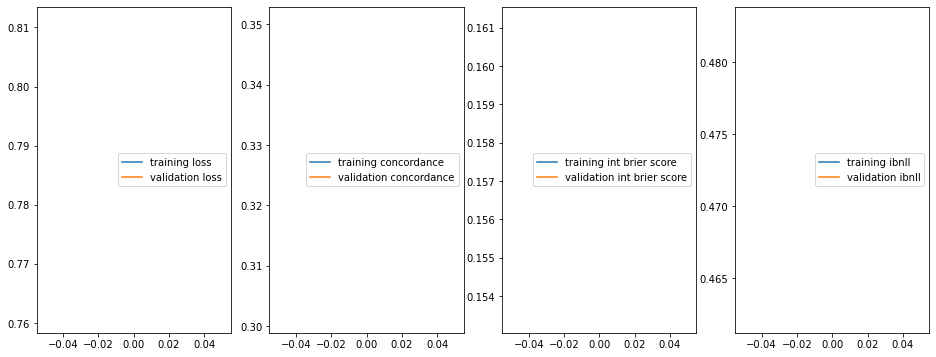

Validation loss decreased (0.760847 --> 0.729963).  Saving model ...
Validation loss decreased (0.729963 --> 0.697596).  Saving model ...
Validation loss decreased (0.697596 --> 0.663701).  Saving model ...
Validation loss decreased (0.663701 --> 0.628282).  Saving model ...
Validation loss decreased (0.628282 --> 0.591441).  Saving model ...
Validation loss decreased (0.591441 --> 0.553446).  Saving model ...
Validation loss decreased (0.553446 --> 0.514831).  Saving model ...
Validation loss decreased (0.514831 --> 0.476429).  Saving model ...
Validation loss decreased (0.476429 --> 0.439500).  Saving model ...
Validation loss decreased (0.439500 --> 0.405737).  Saving model ...


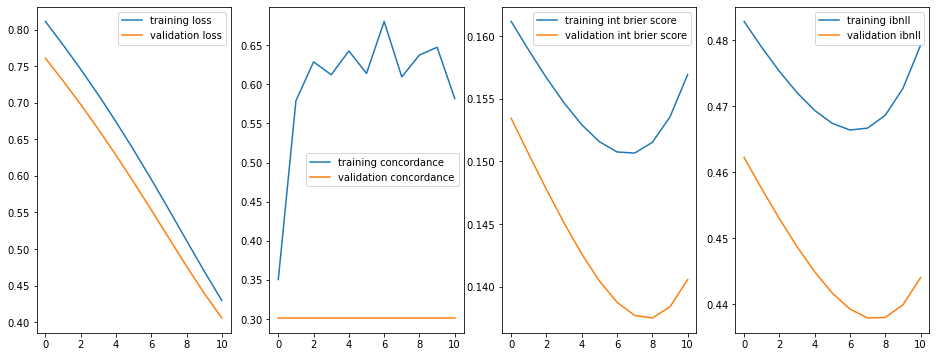

Validation loss decreased (0.405737 --> 0.377107).  Saving model ...
Validation loss decreased (0.377107 --> 0.355454).  Saving model ...
Validation loss decreased (0.355454 --> 0.341675).  Saving model ...
Validation loss decreased (0.341675 --> 0.334784).  Saving model ...
Validation loss decreased (0.334784 --> 0.331757).  Saving model ...
Validation loss decreased (0.331757 --> 0.328554).  Saving model ...
Validation loss decreased (0.328554 --> 0.321907).  Saving model ...
Validation loss decreased (0.321907 --> 0.310560).  Saving model ...
Validation loss decreased (0.310560 --> 0.295293).  Saving model ...
Validation loss decreased (0.295293 --> 0.278183).  Saving model ...


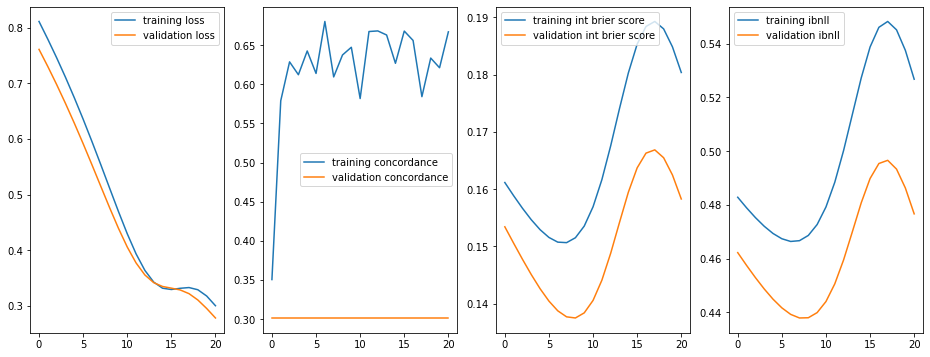

Validation loss decreased (0.278183 --> 0.261666).  Saving model ...
Validation loss decreased (0.261666 --> 0.247744).  Saving model ...
Validation loss decreased (0.247744 --> 0.237483).  Saving model ...
Validation loss decreased (0.237483 --> 0.230813).  Saving model ...
Validation loss decreased (0.230813 --> 0.226610).  Saving model ...
Validation loss decreased (0.226610 --> 0.223223).  Saving model ...
Validation loss decreased (0.223223 --> 0.218951).  Saving model ...
Validation loss decreased (0.218951 --> 0.212386).  Saving model ...
Validation loss decreased (0.212386 --> 0.202677).  Saving model ...
Validation loss decreased (0.202677 --> 0.189569).  Saving model ...


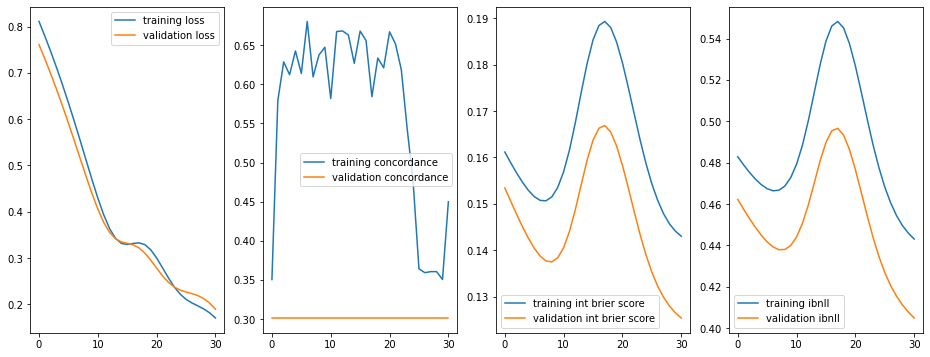

Validation loss decreased (0.189569 --> 0.173381).  Saving model ...
Validation loss decreased (0.173381 --> 0.154948).  Saving model ...
Validation loss decreased (0.154948 --> 0.135397).  Saving model ...
Validation loss decreased (0.135397 --> 0.116014).  Saving model ...
Validation loss decreased (0.116014 --> 0.097775).  Saving model ...
Validation loss decreased (0.097775 --> 0.081057).  Saving model ...
Validation loss decreased (0.081057 --> 0.065533).  Saving model ...
Validation loss decreased (0.065533 --> 0.050634).  Saving model ...
Validation loss decreased (0.050634 --> 0.036226).  Saving model ...
Validation loss decreased (0.036226 --> 0.022949).  Saving model ...


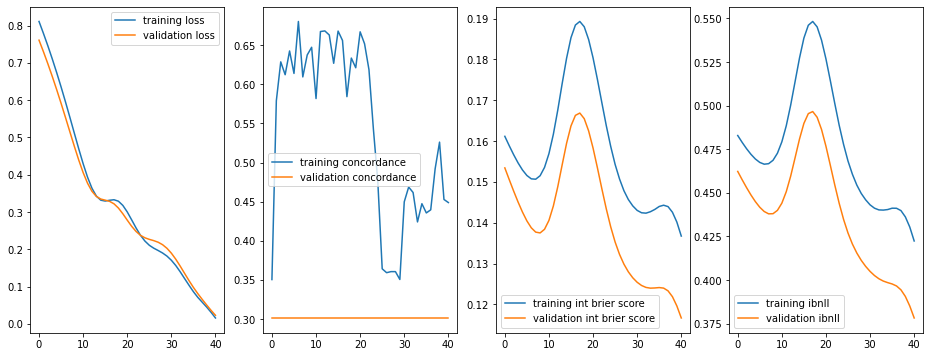

Validation loss decreased (0.022949 --> 0.011852).  Saving model ...
Validation loss decreased (0.011852 --> 0.003551).  Saving model ...
Validation loss decreased (0.003551 --> -0.002880).  Saving model ...
Validation loss decreased (-0.002880 --> -0.010415).  Saving model ...
Validation loss decreased (-0.010415 --> -0.022723).  Saving model ...
Validation loss decreased (-0.022723 --> -0.041413).  Saving model ...
Validation loss decreased (-0.041413 --> -0.064810).  Saving model ...
Validation loss decreased (-0.064810 --> -0.089074).  Saving model ...
Validation loss decreased (-0.089074 --> -0.110780).  Saving model ...
Validation loss decreased (-0.110780 --> -0.128767).  Saving model ...


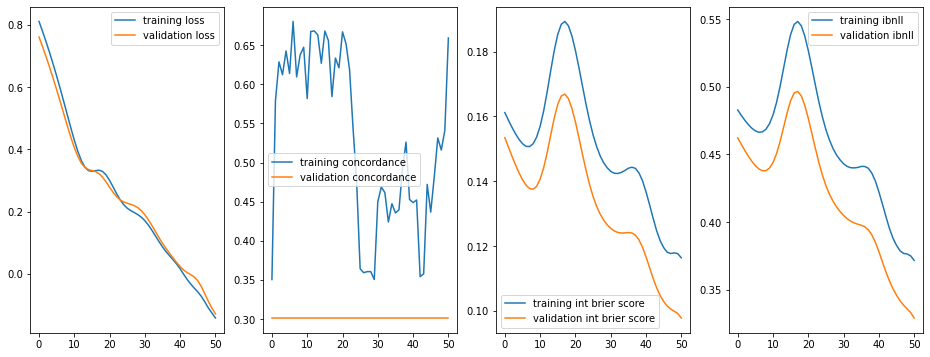

Validation loss decreased (-0.128767 --> -0.142710).  Saving model ...
Validation loss decreased (-0.142710 --> -0.151254).  Saving model ...
Validation loss decreased (-0.151254 --> -0.155225).  Saving model ...
Validation loss decreased (-0.155225 --> -0.164051).  Saving model ...
Validation loss decreased (-0.164051 --> -0.185734).  Saving model ...
Validation loss decreased (-0.185734 --> -0.213263).  Saving model ...
Validation loss decreased (-0.213263 --> -0.234721).  Saving model ...
Validation loss decreased (-0.234721 --> -0.245901).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.245901 --> -0.248255).  Saving model ...


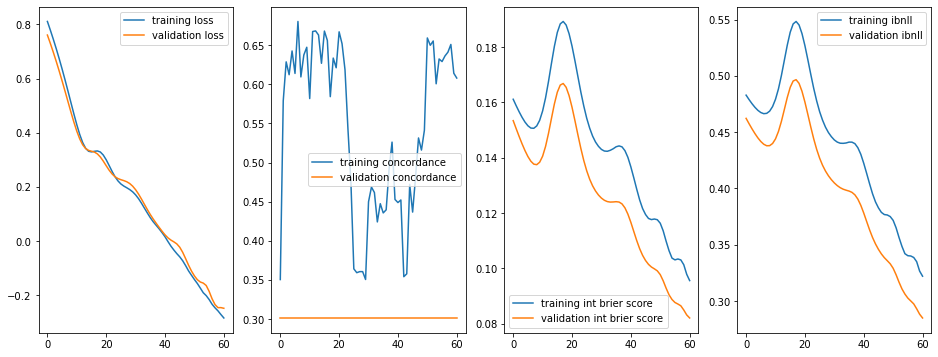

Validation loss decreased (-0.248255 --> -0.271747).  Saving model ...
Validation loss decreased (-0.271747 --> -0.296853).  Saving model ...
Validation loss decreased (-0.296853 --> -0.305206).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.305206 --> -0.332211).  Saving model ...
Validation loss decreased (-0.332211 --> -0.341633).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.341633 --> -0.363459).  Saving model ...


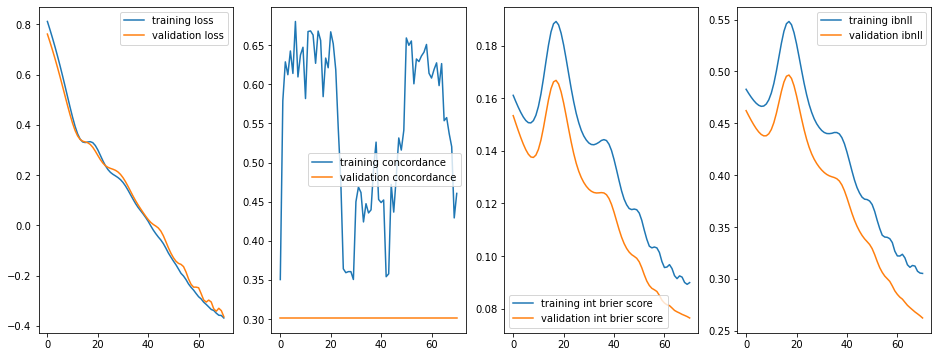

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.363459 --> -0.375152).  Saving model ...
Validation loss decreased (-0.375152 --> -0.382053).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.382053 --> -0.382655).  Saving model ...
Validation loss decreased (-0.382655 --> -0.395826).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.395826 --> -0.403755).  Saving model ...


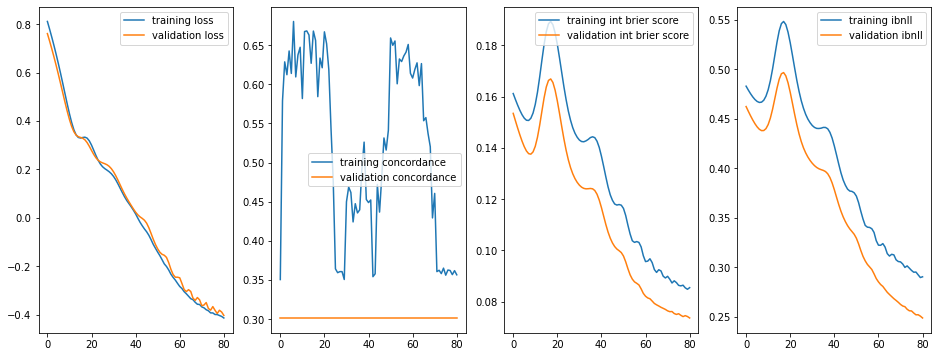

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.403755 --> -0.409608).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.409608 --> -0.413821).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.413821 --> -0.417074).  Saving model ...
EarlyStopping counter: 1 out of 20


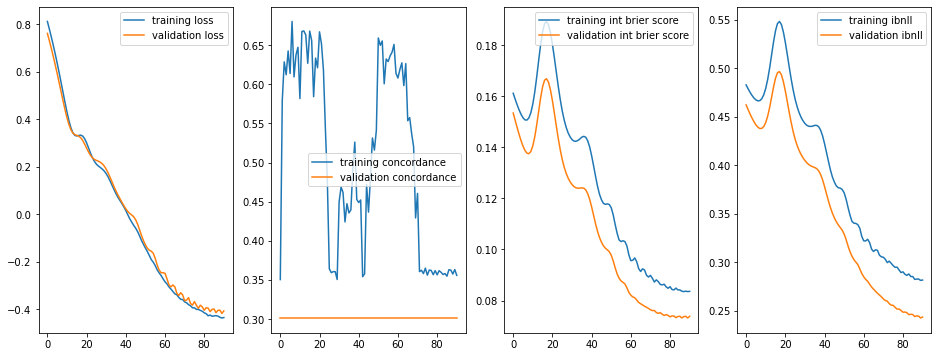

EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.417074 --> -0.419856).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.419856 --> -0.420583).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.420583 --> -0.428671).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.428671 --> -0.433505).  Saving model ...
EarlyStopping counter: 1 out of 20


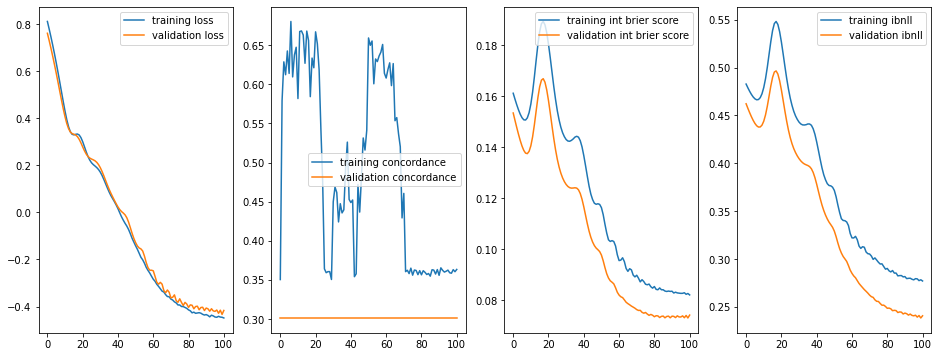

Validation loss decreased (-0.433505 --> -0.440368).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.440368 --> -0.452702).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (-0.452702 --> -0.454556).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (-0.454556 --> -0.458210).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


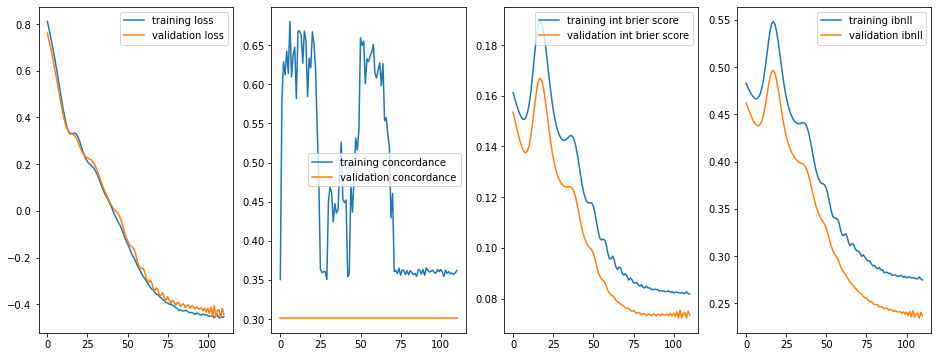

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20


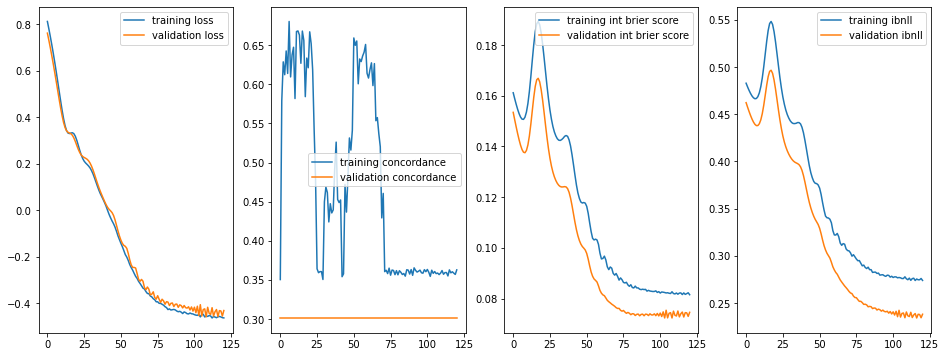

EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping counter: 20 out of 20
Early stopping



In [9]:
lossvals_train = []
lossvals_val = []
loglikes_train = []
loglikes_val = []
conc_val = []
conc_train = []
ibs_val = []
ibs_train = []
ibnll_val = []
ibnll_train = []
    
early_stopping = EarlyStopping("multistate_test",patience=20, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
    for mini,ds in enumerate(train_loader):
        myloss,t2,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()

        lossval += myloss.item()
        loglike += t2.item()
        t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds)
        conc += t1
        ibs += t2
        ibnll += t3

    lossvals_train.append(lossval/len(train_loader))
    loglikes_train.append(loglike/len(train_loader))
    conc_train.append(conc/len(train_loader))
    ibs_train.append(ibs/len(train_loader))
    ibnll_train.append(ibnll/len(train_loader))
        
    odesurv.eval()
    with torch.no_grad():
        lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
        for _,ds in enumerate(val_loader):
            t1,t2,_ = loss(odesurv,*ds)
            lossval += t1.item()
            loglike += t2.item()
            t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds)
            conc += t1
            ibs += t2
            ibnll += t3
        lossvals_val.append(lossval/len(val_loader))
        loglikes_val.append(loglike/len(val_loader))
        conc_val.append(conc/len(val_loader))
        ibs_val.append(ibs/len(val_loader))
        ibnll_val.append(ibnll/len(val_loader))
        early_stopping(lossval/len(val_loader), odesurv)

    if early_stopping.early_stop:
        print("Early stopping")
        break
            
    if i%10==0:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,6))
        ax2.plot(conc_train, label="training concordance")
        ax2.plot(conc_val, label="validation concordance")
        ax2.legend()
        ax3.plot(ibs_train, label="training int brier score")
        ax3.plot(ibs_val, label="validation int brier score")
        ax3.legend()
        ax1.plot(lossvals_train,label="training loss")
        ax1.plot(lossvals_val, label="validation loss")
        ax1.legend()
        ax4.plot(ibnll_train,label="training ibnll")
        ax4.plot(ibnll_val, label="validation ibnll")
        ax4.legend()
        plt.show()

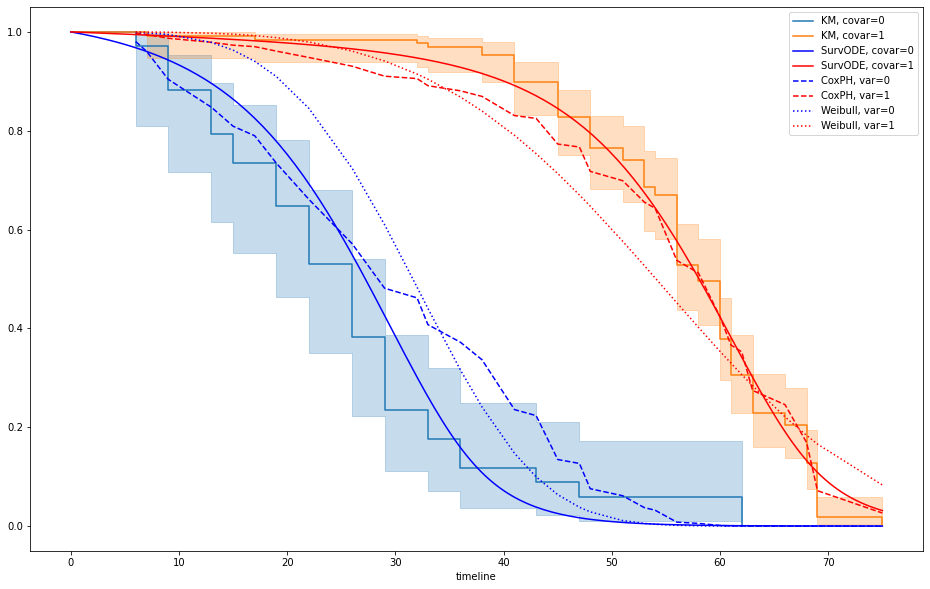

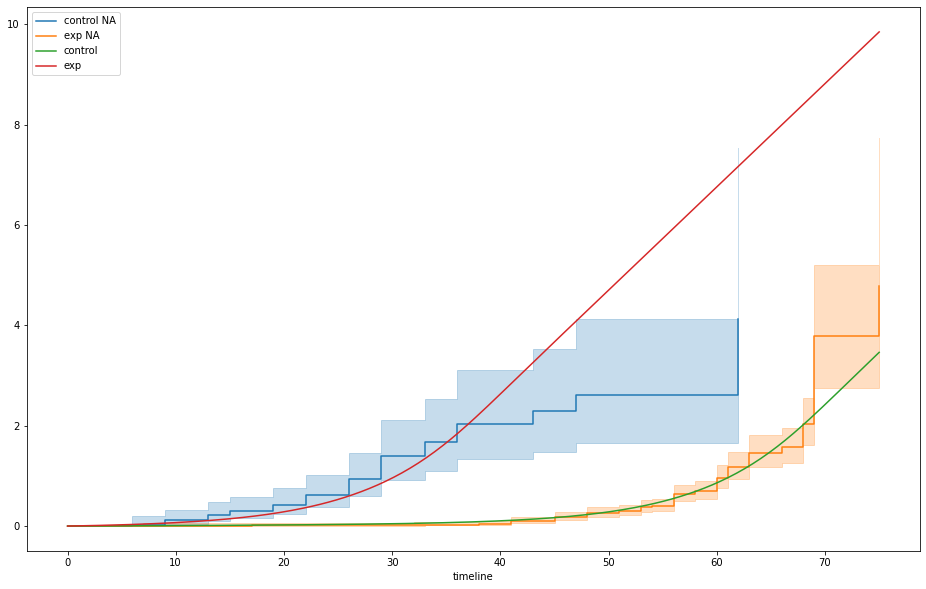

In [21]:
temp_t = torch.from_numpy(np.linspace(0.,1.0,200))
with torch.no_grad():
    out = odesurv.predict(torch.tensor([[0.],[1.]],device=device),temp_t).cpu()

# covariate = 0
pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.])))
predict_surv_first = np.array(pvec[:,0])
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.])))
predict_surv_last = np.array(pvec[:,0])


cph_pred = cph.predict_survival_function(pd.DataFrame({"group":[0,1]}))
wf_pred = wf.predict_survival_function(pd.DataFrame({"group":[0,1]}))
fig,ax = plt.subplots(1,1,figsize=(16,10))
kmf_con.plot(ax=ax, label="KM, covar=0")
kmf_exp.plot(ax=ax, label="KM, covar=1")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),predict_surv_last,label="SurvODE, covar=0",color="blue",ls="-")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),predict_surv_first,label="SurvODE, covar=1",color="red",ls="-")
ax.plot(cph_pred.index,cph_pred[0], label="CoxPH, var=0",color="blue",ls="--")
ax.plot(cph_pred.index,cph_pred[1], label="CoxPH, var=1",color="red",ls="--")
ax.plot(wf_pred.index,wf_pred[0], label="Weibull, var=0",color="blue",ls=":")
ax.plot(wf_pred.index,wf_pred[1], label="Weibull, var=1",color="red",ls=":")
plt.legend()
plt.show()

# ax = plt.subplot(111)
# kmf_con.plot(ax=ax, label="control KM")
# kmf_exp.plot(ax=ax, label="exp KM")
# ax.plot(np.linspace(0,1,200)*max(T1),predict_surv_first,label="control")
# ax.plot(np.linspace(0,1,200)*max(T1),predict_surv_last,label="exp")
# ax.plot(df_pred.index,df_pred[0], label="control Weibull")
# ax.plot(df_pred.index,df_pred[1], label="exp Weibull")
# plt.legend()
# plt.show()

fig, ax = plt.subplots(1,1,figsize=(16,10))
naf_con.plot(ax=ax, label="control NA")
naf_exp.plot(ax=ax, label="exp NA")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),-np.log(predict_surv_first),label="control")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),-np.log(predict_surv_last),label="exp")
plt.legend()
plt.show()

In [117]:
from pycox.models import DeepHitSingle, LogisticHazard
import torchtuples as tt # Some useful functions

num_durations = 100

labtrans = DeepHitSingle.label_transform(num_durations)
# labtrans = LogisticHazard.label_transform(num_durations)

df = load_waltons()

df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

x_train = (df_train.iloc[:,2]=="miR-137").to_numpy().astype("float32").reshape(-1,1)
x_test = (df_test.iloc[:,2]=="miR-137").to_numpy().astype("float32").reshape(-1,1)

get_target = lambda df: (df['T'].values, df['E'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_test = labtrans.fit_transform(*get_target(df_test))

train = (x_train, y_train)
test = (x_test, y_test)



in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = x_train.shape[0]
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs)

0:	[0s / 0s],		train_loss: 1.3161
1:	[0s / 0s],		train_loss: 1.2013
2:	[0s / 0s],		train_loss: 1.1798
3:	[0s / 0s],		train_loss: 1.1687
4:	[0s / 0s],		train_loss: 1.1288
5:	[0s / 0s],		train_loss: 1.1059
6:	[0s / 0s],		train_loss: 1.0757
7:	[0s / 0s],		train_loss: 1.0321
8:	[0s / 0s],		train_loss: 1.0363
9:	[0s / 0s],		train_loss: 0.9843
10:	[0s / 0s],		train_loss: 0.9887
11:	[0s / 0s],		train_loss: 0.9849
12:	[0s / 0s],		train_loss: 0.9431
13:	[0s / 0s],		train_loss: 0.9359
14:	[0s / 0s],		train_loss: 0.9262
15:	[0s / 0s],		train_loss: 0.9317
16:	[0s / 0s],		train_loss: 0.9123
17:	[0s / 0s],		train_loss: 0.8896
18:	[0s / 0s],		train_loss: 0.9016
19:	[0s / 0s],		train_loss: 0.8828
20:	[0s / 0s],		train_loss: 0.8661
21:	[0s / 0s],		train_loss: 0.8810
22:	[0s / 0s],		train_loss: 0.8692
23:	[0s / 0s],		train_loss: 0.8646
24:	[0s / 0s],		train_loss: 0.8652
25:	[0s / 0s],		train_loss: 0.8657
26:	[0s / 0s],		train_loss: 0.8428
27:	[0s / 0s],		train_loss: 0.8570
28:	[0s / 0s],		train_loss: 0.

In [130]:
surv = model.interpolate(100).predict_surv_df(x_test).astype("float32")
ev = EvalSurv(surv, df_test["T"].to_numpy(), df_test["E"].to_numpy(), censor_surv='km')
ev.concordance_td("antolini")

time_grid = np.linspace(df_test["T"].to_numpy().min(), df_test["T"].to_numpy().max(), 100)
ev.integrated_brier_score(time_grid)

0.1324302983039809

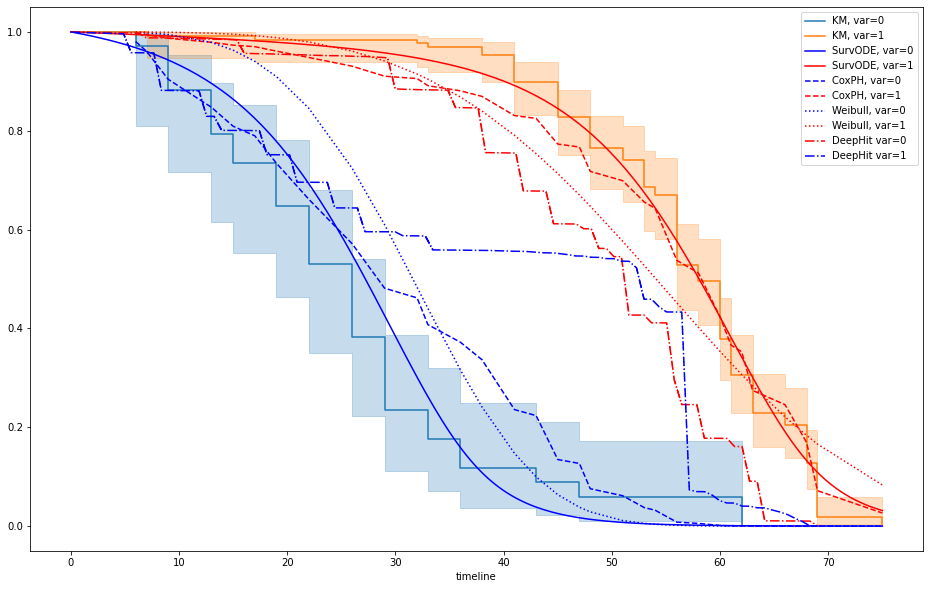

In [119]:
surv = model.interpolate(100).predict_surv_df(np.array([[0.],[1.]]).astype("float32"))
surv = surv.rename(columns={0:"DeepHit var=0", 1:"DeepHit var=1"})

cph_pred = cph.predict_survival_function(pd.DataFrame({"group":[0,1]}))
wf_pred = wf.predict_survival_function(pd.DataFrame({"group":[0,1]}))
fig,ax = plt.subplots(1,1,figsize=(16,10))
kmf_con.plot(ax=ax, label="KM, var=0")
kmf_exp.plot(ax=ax, label="KM, var=1")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),predict_surv_last,label="SurvODE, var=0",color="blue",ls="-")
ax.plot(np.linspace(0,1,200)*Tmax.cpu().numpy(),predict_surv_first,label="SurvODE, var=1",color="red",ls="-")
ax.plot(cph_pred.index,cph_pred[0], label="CoxPH, var=0",color="blue",ls="--")
ax.plot(cph_pred.index,cph_pred[1], label="CoxPH, var=1",color="red",ls="--")
ax.plot(wf_pred.index,wf_pred[0], label="Weibull, var=0",color="blue",ls=":")
ax.plot(wf_pred.index,wf_pred[1], label="Weibull, var=1",color="red",ls=":")
surv.iloc[:, :2].plot(drawstyle='steps-post',color=["red","blue"],ls="-.",ax=ax)
plt.legend()
plt.show()

# Coxed

In [10]:
%%R -o survdata -o baseline -o betas -o ind_survival
library(coxed)
library(dplyr)

beta <- matrix(c(rep(0.4,100),c(-1:50/50,(1:50)/25-1),c(1:50/50,-(1:50)/25+1)),nrow=100,ncol=3)
simdata <- sim.survdata(N=4096, T=100, xvars=3, beta=beta, type="tvbeta", num.data.frames=1)

survdata <- simdata$data
survdata <- survdata %>% mutate(Tstart=0,From=1,To=2,trans=1) %>% rename(status=failed,Tstop=y) %>% select(From,To,trans,Tstart,Tstop,status,contains("X"))

baseline <- simdata$baseline
betas <- simdata$betas
ind_survival <- simdata$ind.survive

In [11]:
survdata.to_csv("survival_sim_km.csv")

# Metabric

In [4]:
from sklearn_pandas import DataFrameMapper
import pandas as pd
from sklearn.preprocessing import StandardScaler

def make_dataloader(df,Tmax,batchsize):
    cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
    cols_leave = ['x4', 'x5', 'x6', 'x7']

    standardize = [([col], StandardScaler()) for col in cols_standardize]
    leave = [(col, None) for col in cols_leave]

    x_mapper = DataFrameMapper(standardize + leave)
    X = x_mapper.fit_transform(df).astype('float32')
    
    X = torch.from_numpy(X).float().to(device)
    T = torch.from_numpy(df[["duration"]].values).float().flatten().to(device)
    Tmax = torch.tensor(Tmax).to(device)
    T = T/Tmax
    T[T==0] = 1e-8
    E = torch.from_numpy(df[["event"]].values).float().flatten().to(device)

    Tstart = torch.from_numpy(np.array([0 for i in range(T.shape[0])])).float().to(device)
    From = torch.tensor([1],device=device).repeat((T.shape))
    To = torch.tensor([2],device=device).repeat((T.shape))
    trans = torch.tensor([1],device=device).repeat((T.shape))

    dataset = TensorDataset(X,Tstart,T,From,To,trans,E)
    loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    return loader

In [21]:
def odesurv_manual_benchmark(df_train, df_test,config):
    torch.cuda.empty_cache()
    df_val = df_train.sample(frac=0.15)
    df_train = df_train.drop(df_val.index)
    
    Tmax = df_train["duration"].max()
    
    train_loader = make_dataloader(df_train,Tmax/config["multiplier"],config["batch_size"])
    val_loader = make_dataloader(df_val,Tmax/config["multiplier"],len(df_val))
    
    num_in = 9
    num_latent = config["num_latent"]
    layers_encoder =  [config["encoder_neurons"]]*config["num_encoder_layers"]
    dropout_encoder = [config["encoder_dropout"]]*config["num_encoder_layers"]
    layers_odefunc =  [config["odefunc_neurons"]]*config["num_odefunc_layers"]
    dropout_odefunc = []

    trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

    encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
    odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc,config["softplus_beta"]).to(device)
    block = ODEBlock(odefunc).to(device)
    odesurv = ODEsurv(block,encoder).to(device)

    optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = config["weight_decay"], lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.2)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=10, verbose="True")
    
    early_stopping = EarlyStopping("test",patience=config["patience"], verbose=True)
    for i in tqdm(range(1000)):
        odesurv.train()
        for mini,ds in enumerate(train_loader):
            myloss,_,_ = loss(odesurv,*ds,mu=config["mu"])
            optimizer.zero_grad()
            myloss.backward()    
            optimizer.step()
        
        odesurv.eval()
        with torch.no_grad():
            lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
            for _,ds in enumerate(val_loader):
                t1,_,_ = loss(odesurv,*ds,mu=config["mu"])
                lossval += t1.item()
                t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds,multiplier=config["multiplier"])
                conc += t1
                ibs += t2
                ibnll += t3
            early_stopping(lossval/len(val_loader), odesurv)
            scheduler.step(lossval/len(val_loader))
            print("lossval: "+str(lossval/len(val_loader))+" c: "+str(conc/len(val_loader))+" ibs: "+str(ibs/len(val_loader))+" ibnll: "+str(ibnll/len(val_loader)))
        if early_stopping.early_stop:
            print("Early stopping")
            break

    odesurv.load_state_dict(torch.load('test_checkpoint.pt'))
        
    loader = make_dataloader(df_test,Tmax/config["multiplier"],len(df_test))

    odesurv.eval()
    with torch.no_grad():
        conc,ibs,ibnll = 0., 0., 0.
        for _,ds in enumerate(loader):
            t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds,multiplier=config["multiplier"])
            conc += t1
            ibs += t2
            ibnll += t3
    return conc/len(loader), ibs/len(loader), ibnll/len(loader)

In [22]:
from sklearn.model_selection import KFold
from pycox import datasets

kfold = KFold(5, shuffle=True)
df_all = datasets.metabric.read_df()
gen = kfold.split(df_all)

config = {
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "num_latent": 200,
    "encoder_neurons": 10,
    "num_encoder_layers": 2,
    "encoder_dropout": 0.1,
    "odefunc_neurons": 400,
    "num_odefunc_layers": 1,
    "batch_size": 512,
    "multiplier": 3.,
    "mu": 1e-4,
    "patience": 20,
    "softplus_beta": 1.
}

odesurv_bench_vals = []
for g in gen:
    df_train = df_all.iloc[g[0]]
    df_test =  df_all.iloc[g[1]]
    conc, ibs, ibnll = odesurv_manual_benchmark(df_train,df_test,config)
    odesurv_bench_vals.append([conc,ibs,ibnll])

NameError: name 'T' is not defined

In [ ]:
print("c="+str(np.mean(np.array(odesurv_bench_vals)[:,0]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,0])))
print("ibs="+str(np.mean(np.array(odesurv_bench_vals)[:,1]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,1])))
print("ibnll="+str(np.mean(np.array(odesurv_bench_vals)[:,2]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,2])))

# ROT

In [26]:
from sklearn_pandas import DataFrameMapper
import pandas as pd
from sklearn.preprocessing import StandardScaler

def make_dataloader(df,Tmax,batchsize):
    cols_standardize = ['x3', 'x4', 'x5', 'x6']
    cols_leave = ['x0', 'x1', 'x2']

    standardize = [([col], StandardScaler()) for col in cols_standardize]
    leave = [(col, None) for col in cols_leave]

    x_mapper = DataFrameMapper(standardize + leave)
    X = x_mapper.fit_transform(df).astype('float32')
    
    X = torch.from_numpy(X).float().to(device)
    T = torch.from_numpy(df[["duration"]].values).float().flatten().to(device)
    Tmax = torch.tensor(Tmax).to(device)
    T = T/Tmax
    T[T==0] = 1e-8
    E = torch.from_numpy(df[["event"]].values).float().flatten().to(device)

    Tstart = torch.from_numpy(np.array([0 for i in range(T.shape[0])])).float().to(device)
    From = torch.tensor([1],device=device).repeat((T.shape))
    To = torch.tensor([2],device=device).repeat((T.shape))
    trans = torch.tensor([1],device=device).repeat((T.shape))

    dataset = TensorDataset(X,Tstart,T,From,To,trans,E)
    loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    return loader

In [27]:
def odesurv_manual_benchmark(df_train, df_test,config):
    torch.cuda.empty_cache()
    df_val = df_train.sample(frac=config["traintest_fraction"])
    df_train = df_train.drop(df_val.index)
    
    Tmax = df_train["duration"].max()
    
    train_loader = make_dataloader(df_train,Tmax/config["multiplier"],config["batch_size"])
    val_loader = make_dataloader(df_val,Tmax/config["multiplier"],len(df_val))
    test_loader = make_dataloader(df_test,Tmax/config["multiplier"],len(df_test))
    
    num_in = 7
    num_latent = config["num_latent"]
    layers_encoder =  [config["encoder_neurons"]]*config["num_encoder_layers"]
    dropout_encoder = [config["encoder_dropout"]]*config["num_encoder_layers"]
    layers_odefunc =  [config["odefunc_neurons"]]*config["num_odefunc_layers"]
    dropout_odefunc = []

    trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

    encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
    odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc,config["softplus_beta"]).to(device)
    block = ODEBlock(odefunc).to(device)
    odesurv = ODEsurv(block,encoder).to(device)

    optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = config["weight_decay"], lr=config["lr"])
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config["scheduler_epochs"], gamma=config["scheduler_factor"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config["scheduler_factor"], patience=config["scheduler_epochs"], verbose="True")
    
    early_stopping = EarlyStopping("test",patience=config["patience"], verbose=True)
    for i in tqdm(range(1000)):
        odesurv.train()
        for mini,ds in enumerate(train_loader):
            myloss,_,_ = loss(odesurv,*ds,mu=config["mu"])
            optimizer.zero_grad()
            myloss.backward()    
            optimizer.step()
        
        odesurv.eval()
        with torch.no_grad():
            lossval,loglike,conc,ibs,ibnll = 0., 0., 0., 0., 0.
            for _,ds in enumerate(val_loader):
                t1,_,_ = loss(odesurv,*ds,mu=config["mu"])
                lossval += t1.item()
                t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds,multiplier=config["multiplier"])
                conc += t1
                ibs += t2
                ibnll += t3
            conc_test,ibs_test,ibnll_test = 0., 0., 0.
            for _,ds in enumerate(test_loader):
                t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds,multiplier=config["multiplier"])
                conc_test += t1
                ibs_test += t2
                ibnll_test += t3
            early_stopping(lossval/len(val_loader), odesurv)
            scheduler.step(lossval/len(val_loader))
            print("lossval: "+str(lossval/len(val_loader))+" c: "+str(conc/len(val_loader))+" ibs: "+str(ibs/len(val_loader))+" ibnll: "+str(ibnll/len(val_loader)))

        if early_stopping.early_stop:
            print("Early stopping")
            break

    odesurv.load_state_dict(torch.load('test_checkpoint.pt'))
    
    odesurv.eval()
    with torch.no_grad():
        conc,ibs,ibnll = 0., 0., 0.
        for _,ds in enumerate(test_loader):
            t1,t2,t3 = measures(odesurv,torch.tensor([1.,0.],device=device),*ds,multiplier=config["multiplier"])
            conc += t1
            ibs += t2
            ibnll += t3
    return conc/len(test_loader), ibs/len(test_loader), ibnll/len(test_loader)

In [38]:
from sklearn.model_selection import KFold
from pycox import datasets

kfold = KFold(5,shuffle=True)
df_all = datasets.gbsg.read_df()
gen = kfold.split(df_all)

config = {
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "num_latent": 100,
    "encoder_neurons": 20,
    "num_encoder_layers": 1,
    "encoder_dropout": 0.2,
    "odefunc_neurons": 500,
    "num_odefunc_layers": 2,
    "batch_size": 512,
    "multiplier": 1.,
    "mu": 1e-4,
    "patience": 20,
    "softplus_beta": 1.,
    "scheduler_epochs": 10,
    "scheduler_factor": 0.2,
    "traintest_fraction": 0.2
}

odesurv_bench_vals = []
for g in gen:
    df_train = df_all.iloc[g[0]]
    df_test =  df_all.iloc[g[1]]
    conc, ibs, ibnll = odesurv_manual_benchmark(df_train,df_test,config)
    odesurv_bench_vals.append([conc,ibs,ibnll])

Validation loss decreased (inf --> 1.179267).  Saving model ...
lossval: 1.179267406463623 c: 0.5888189825633651 ibs: 0.1933224667345694 ibnll: 0.5626817818390629
Validation loss decreased (1.179267 --> 1.139375).  Saving model ...
lossval: 1.1393752098083496 c: 0.6420995865540177 ibs: 0.18423353631585696 ibnll: 0.5405162554172288
EarlyStopping counter: 1 out of 20
lossval: 1.1713223457336426 c: 0.6408053208700342 ibs: 0.19207910085734045 ibnll: 0.5549472299959054
Validation loss decreased (1.139375 --> 1.122724).  Saving model ...
lossval: 1.122724175453186 c: 0.6371382347654143 ibs: 0.1822952823462328 ibnll: 0.5355631675894665
EarlyStopping counter: 1 out of 20
lossval: 1.1245818138122559 c: 0.6379291749056265 ibs: 0.18295944151285695 ibnll: 0.5369277794215472
EarlyStopping counter: 2 out of 20
lossval: 1.1441798210144043 c: 0.6393312960632752 ibs: 0.18840263636913027 ibnll: 0.5471818660495313
Validation loss decreased (1.122724 --> 1.095435).  Saving model ...
lossval: 1.09543478488

Validation loss decreased (inf --> 1.150381).  Saving model ...
lossval: 1.1503814458847046 c: 0.6409755751207044 ibs: 0.19467804796333296 ibnll: 0.5657540136828151
Validation loss decreased (1.150381 --> 1.117411).  Saving model ...
lossval: 1.1174113750457764 c: 0.6738142573132633 ibs: 0.18508750588484404 ibnll: 0.5430086750382574
Validation loss decreased (1.117411 --> 1.068009).  Saving model ...
lossval: 1.0680090188980103 c: 0.672678216415791 ibs: 0.1743842785121724 ibnll: 0.5174045079827144
Validation loss decreased (1.068009 --> 1.046303).  Saving model ...
lossval: 1.0463029146194458 c: 0.6704771371769384 ibs: 0.16833369757652894 ibnll: 0.5036826079289761
EarlyStopping counter: 1 out of 20
lossval: 1.0508173704147339 c: 0.6743467764839535 ibs: 0.17216632042432434 ibnll: 0.5123518873137972
EarlyStopping counter: 2 out of 20
lossval: 1.0529402494430542 c: 0.6755893212155638 ibs: 0.17357497419269283 ibnll: 0.5157755164208503
EarlyStopping counter: 3 out of 20
lossval: 1.060629487

Validation loss decreased (inf --> 1.107942).  Saving model ...
lossval: 1.1079418659210205 c: 0.6342619350364119 ibs: 0.1976488041600266 ibnll: 0.5722383648436193
Validation loss decreased (1.107942 --> 1.058841).  Saving model ...
lossval: 1.0588407516479492 c: 0.6939082187030401 ibs: 0.18225098881351232 ibnll: 0.5368610441650352
Validation loss decreased (1.058841 --> 1.011084).  Saving model ...
lossval: 1.011083960533142 c: 0.699302585442916 ibs: 0.16702495318138136 ibnll: 0.5020841622336721
Validation loss decreased (1.011084 --> 0.994232).  Saving model ...
lossval: 0.9942322969436646 c: 0.7021538935768504 ibs: 0.165088487779975 ibnll: 0.4971961475922897
Validation loss decreased (0.994232 --> 0.983333).  Saving model ...
lossval: 0.983333170413971 c: 0.7056602319577698 ibs: 0.16444088929713266 ibnll: 0.49505501248542655
Validation loss decreased (0.983333 --> 0.975869).  Saving model ...
lossval: 0.9758691191673279 c: 0.7043116402728008 ibs: 0.1648132486915113 ibnll: 0.49544975

Validation loss decreased (inf --> 1.109504).  Saving model ...
lossval: 1.1095043420791626 c: 0.6541347712960519 ibs: 0.19387356307452996 ibnll: 0.5649297687087843
Validation loss decreased (1.109504 --> 1.060985).  Saving model ...
lossval: 1.0609848499298096 c: 0.679776763829707 ibs: 0.1801883475371564 ibnll: 0.5332592335514293
Validation loss decreased (1.060985 --> 1.016971).  Saving model ...
lossval: 1.0169705152511597 c: 0.6815490780195331 ibs: 0.17070207441445495 ibnll: 0.5098799018917253
Validation loss decreased (1.016971 --> 1.001783).  Saving model ...
lossval: 1.0017831325531006 c: 0.6829443040838644 ibs: 0.16870022370524443 ibnll: 0.5041936064895216
Validation loss decreased (1.001783 --> 0.998246).  Saving model ...
lossval: 0.9982455968856812 c: 0.6899958520306195 ibs: 0.16773658901520702 ibnll: 0.5028702508908827
Validation loss decreased (0.998246 --> 0.997307).  Saving model ...
lossval: 0.9973067045211792 c: 0.692786304159282 ibs: 0.1687819556870606 ibnll: 0.505053

Validation loss decreased (inf --> 1.152089).  Saving model ...
lossval: 1.1520886421203613 c: 0.6325757575757576 ibs: 0.19319328444705133 ibnll: 0.5622247248453216
Validation loss decreased (1.152089 --> 1.104428).  Saving model ...
lossval: 1.1044280529022217 c: 0.6611333927510398 ibs: 0.1816219105411592 ibnll: 0.5342783588167718
Validation loss decreased (1.104428 --> 1.073802).  Saving model ...
lossval: 1.0738022327423096 c: 0.6656268568033273 ibs: 0.1761713826832543 ibnll: 0.522445127018811
EarlyStopping counter: 1 out of 20
lossval: 1.0779931545257568 c: 0.6635843731431966 ibs: 0.17775227716230016 ibnll: 0.5264213158153396
EarlyStopping counter: 2 out of 20
lossval: 1.082067608833313 c: 0.6653297682709447 ibs: 0.17736920623390282 ibnll: 0.5231749494442314
Validation loss decreased (1.073802 --> 1.057842).  Saving model ...
lossval: 1.0578420162200928 c: 0.6659610814022578 ibs: 0.17665762464174053 ibnll: 0.5216140852179566
Validation loss decreased (1.057842 --> 1.047712).  Savin

In [39]:
print("c="+str(np.mean(np.array(odesurv_bench_vals)[:,0]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,0])))
print("ibs="+str(np.mean(np.array(odesurv_bench_vals)[:,1]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,1])))
print("ibnll="+str(np.mean(np.array(odesurv_bench_vals)[:,2]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,2])))

c=0.6755800439501767+-0.007289935702651632
ibs=0.1748114203382894+-0.004882900790128719
ibnll=0.5172120182038087+-0.010786319240829012


In [19]:
print("c="+str(np.mean(np.array(odesurv_bench_vals)[:,0]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,0])))
print("ibs="+str(np.mean(np.array(odesurv_bench_vals)[:,1]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,1])))
print("ibnll="+str(np.mean(np.array(odesurv_bench_vals)[:,2]))+"+-"+str(np.std(np.array(odesurv_bench_vals)[:,2])))

c=0.6763719645689872+-0.018007772857914835
ibs=0.17339400110183745+-0.005680101267687533
ibnll=0.5138774717642108+-0.01382724406752162
